# Workflow da solução proposta.
# OBS: Se possível utilizar funções Helper em pacote específico para aumentar o nivel de abstração neste "documento".

Download das Setenças de ACP do TRT1 oriundas de lista obtida com scrapy na consulta pública do Tribunal

In [ ]:
# 
# scrapy = Scrap()
# scrapy.setUrlPesq("https://bibliotecadigital.trt1.jus.br/...")
# scrapy.setDsFolder("\home\info\MyNotebooks\SentencasTRT1\PDFs")
# scrapy.downloadPDFs(int, int)  
#      passa o intervalo na paginação de pesquisa a partir do qual os resultados retornados serao processados/baixados
#      chama a função private createList() para gerar a lista dos para os links diretos pdfs e a salva em um arquivo .csv
#      chama a função private downloadLinks() para fazer o download dos links diretos para os arquivos contidos no .csv salvo. Salva os arquivos em .pdf
#
# corpusTRT1 = Corpus()
# corpusTRT1.setDsFolder("\home\info\MyNotebooks\SentencasTRT1\Corpus")
# corpusTRT1.createTXT()  # Salva na subpasta \txt. Podemos criar um txt para cada arquivo .pdf ou um .txt gigante com o conteudo de todos os .pdf mas isso pode gerar problemas de memoria
# corpusTRT1.createCSV()  # Salva na subpasta \csv
# corpusTRT1.createDSDict() # Salva na subpasta \DS. Pega um .csv ou uma pasta com txt e cria o DatasetDict.
#
# 
# Pega o corpus escolhido (.csv, ds, txt) e faz a extração do conteudo criando um arquivo estruturado (.csv ou DsDict).
# X = ObjetoClasse()
# ds = X.readDS() ou X.readTXT() ou X.readCSV()
# ds_structd = X.extract(ds)
# X.save(ds_structd)
#


In [1]:
%%writefile HelperFunctions/Scrap/Scrap.py
# 1.
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import csv
from csv import reader
import os
import time

class Scrap():
    
    def __init__(self):
        self.URL_TRT  = "https://bibliotecadigital.trt1.jus.br"
        self.URL_PESQ = "https://bibliotecadigital.trt1.jus.br/jspui/handle/1001/685849/simple-search?query=a%C3%A7%C3%A3o+civil+p%C3%BAblica"
        self.new_page = 'https://bibliotecadigital.trt1.jus.br/jspui/handle/1001/685849/simple-search?query=a%C3%A7%C3%A3o+civil+p%C3%BAblica&sort_by=score&order=desc&location=1001/685849&rpp=10&etal=0&start='
        self.arq_links_pdfs = 'links_pdfs_TRT1.csv'
        self.FOLDER_BASE = "/home/info/MyNotebooks/Datasets/SentencasTRT1/"
        self.list_links = list()
        self.start_page = 16010
        self.end_page = 16020
        self.idx = 0
        
    
    def setUrlPesq(self, URL):
        self.URL_PESQ = URL
        
    def setDsFolder(self, URL):
        self.DS_FOLDER = URL
        
    def criaListaLinks(self):
        html = urlopen(self.URL_PESQ)
        bsObj = BeautifulSoup(html.read())

        # obtem uma lista contendo todos os processos referenciados na pagina atual
        list_processos = bsObj.findAll('a', href=True, attrs={'style': 'font-size: large;'})
        
        for i in list_processos:
            nr_processo = i.contents[0]
            # print(nr_processo)
            pagina_processo = self.URL_TRT + i.get('href')
            # print(pagina_processo)
            html_processo = urlopen(pagina_processo)
            bs_processo = BeautifulSoup(html_processo.read())
            link_pdf = self.URL_TRT + bs_processo.find('a', href=True, attrs={'target': '_blank'})['href']
            self.list_links.append(link_pdf)
            
        
          
    def downloadListaPDFs(self, inicio, fim):
        self.start_page = int(str(inicio))
        self.end_page   = int(str(fim))
        
        self.idx = 0
        
        # considerando que temos 10 links de pdfs por pagina o passo sera 10 (em cada pagina 10 links sao extraídos)
        for k in range(self.start_page, self.end_page, 10):
          self.setUrlPesq(self.new_page+str(k))
          self.criaListaLinks()
          self.idx = k      
        
        self.arq_links_pdfs = 'links_pdfs_TRT1-from-'+str(self.start_page)+'-to-'+str(self.end_page)+'-idx='+str(self.idx)+'.csv'
        return(self.arq_links_pdfs)

            
    def saveCSV(self):
        
        #if not os.path.isdir(self.FOLDER_BASE):
        #    os.makedirs(self.FOLDER_BASE)

        # 1. abrir o arquivo e grava os links para download num .csv
        
        print(len(self.list_links))
        for i in range(len(self.list_links)):
            print(self.list_links[i])
        
        
        with open('{file_path}'.format(file_path=os.path.join(self.FOLDER_BASE, self.arq_links_pdfs)), 'w', newline='', encoding='utf-8') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerows(([str(row)] for row in self.list_links))
        csv_file.close()

        
    def downloadPDFs(self, file):
        arquivo = self.FOLDER_BASE+file
        lista_links = list()
        
        # Abre o arquivo.csv contendo os links diretos dos PDFs.
        with open(arquivo, "r", newline="", encoding="utf-8") as f:
            csv_reader = reader(f)

            # Iterate over each row in the csv using reader object
            for row in csv_reader:
                # row variable is a list that represents a row in csv
                lista_links.append(row)
                # self.list_links.append(f.read().split(','))
            
        f.close()         
        print(len(lista_links))
        
        for i in range(len(lista_links)):
            lista_links[i] = str(lista_links[i]).replace("\n", "")
            lista_links[i] = str(lista_links[i]).replace("\r", "")
            lista_links[i] = str(lista_links[i]).replace("\"", "")
            lista_links[i] = str(lista_links[i]).replace("[\'", "")
            lista_links[i] = str(lista_links[i]).replace("\']", "")
            
        
        
        #Faz o download de cada item da lista (link direto do pdf) e grava em um arquivo pdf na pasta.
        for i in range(len(lista_links)):
            print(type(lista_links))
            pdf = str(lista_links[i])
            print(pdf)
            print(type(pdf))
            response = requests.get(pdf)
            processo = lista_links[i].split("/")[-1]
            arq_dest = self.FOLDER_BASE+"/PDFs/"+processo
            with open(arq_dest, 'wb') as f:
                f.write(response.content)
            f.close()

                 

Overwriting HelperFunctions/Scrap/Scrap.py


In [2]:
# 2.
from HelperFunctions.Scrap.Scrap import Scrap

In [3]:
# 3.
%run -i HelperFunctions/Scrap/Scrap.py

In [4]:
# 4. 
scrapy = Scrap()

In [5]:
# 5.
%%time
arq = scrapy.downloadListaPDFs(1,1000)
scrapy.saveCSV()

/home/info/MyNotebooks/HelperFunctions/Scrap/Scrap.py:32: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 32 of the file HelperFunctions/Scrap/Scrap.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  bsObj = BeautifulSoup(html.read())
/home/info/MyNotebooks/HelperFunctions/Scrap/Scrap.py:43: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 43 of the file HelperFunct

998
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1566814/1/01009587820185010076-DEJT-27-11-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2192757/1/01009418520185010482-DEJT-17-02-2020.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1037013/1/01003182020185010062-DOERJ-16-05-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1105127/1/01003182020185010062-DEJT-16-05-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1036902/1/01003208720185010062-DOERJ-16-05-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1105126/1/01003208720185010062-DEJT-16-05-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2917779/1/01004201120215010006-DEJT-05-04-2022.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1084070/1/01004415920185010501-DEJT-03-07-2018.pdf
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1559616/1/01012913920175010246-DEJT-11-10-2018.pdf
http

In [6]:
# 6.
%%time
scrapy.downloadPDFs(arq)

998
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1566814/1/01009587820185010076-DEJT-27-11-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2192757/1/01009418520185010482-DEJT-17-02-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1037013/1/01003182020185010062-DOERJ-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1105127/1/01003182020185010062-DEJT-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1036902/1/01003208720185010062-DOERJ-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1105126/1/01003208720185010062-DEJT-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2917779/1/01004201120215010006-DEJT-05-04-2022.pdf
<class 'str'>
<class 'list'>
https:

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1744152/1/01002144820185010411-DEJT-17-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1081558/1/01003329420185010032-DEJT-29-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1029504/1/01002253620185010069-DOERJ-05-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1142846/1/01002253620185010069-DEJT-09-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1142837/1/01002037520185010069-DEJT-09-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1154244/1/01003611920185010203-DEJT-20-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1029493/1/01002037520185010069-DOERJ-05-04-2018.pdf
<class 'str'>
<class 'list'>
https://bi

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1522824/1/01002214420185010054-DEJT-25-10-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1842035/1/01004174020185010401-DEJT-14-08-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1037124/1/01003996620185010062-DOERJ-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1105193/1/01003996620185010062-DEJT-16-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1073974/1/01001813820185010062-DEJT-26-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1726688/1/01014129220175010561-DEJT-06-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1789613/1/01001822220185010030-DEJT-24-06-2019.pdf
<class 'str'>
<class 'list'>
https://bib

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1782317/1/01695004820025010032-DEJT-19-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1540350/1/00007869420125010511-DEJT-11-12-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1758432/1/01598008120095010071-DEJT-30-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1466854/1/00109680820155010068-DEJT-16-10-2017.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1520471/1/01003553320185010002-DEJT-22-10-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1397065/1/01013949320165010080-DEJT-26-05-2017.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1387700/1/01009663820165010072-DEJT-19-04-2017.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1038251/1/01003107320185010343-DOERJ-15-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1152719/1/01001903020185010343-DEJT-19-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1057992/1/01003210520185010343-DEJT-30-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1110603/1/01003210520185010343-DEJT-01-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2330839/1/01000363820205010053-DEJT-15-06-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1026447/1/01001595820185010036-DOERJ-27-03-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1186688/1/01001595820185010036-DEJT-27-03-2018.pdf
<class 'str'>
<class 'list'>
https://bi

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1134978/1/01002193820185010066-DEJT-25-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1122445/1/01003224520185010066-DEJT-15-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2216882/1/01001876720205010032-DEJT-16-03-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1048722/1/01002939220185010066-DEJT-11-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1903138/1/01010145420195010019-DEJT-09-10-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1878420/1/01008974320195010058-DEJT-21-08-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1653179/1/01018713820175010224-DEJT-26-02-2019.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1058058/1/01002948520185010031-DEJT-28-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1128656/1/01002906320185010026-DEJT-14-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1038283/1/01003026220185010031-DOERJ-15-05-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1225376/1/01002150920185010031-DEJT-24-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1214741/1/01002615220185010207-DEJT-10-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1022370/1/01001960320185010031-DOERJ-25-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1029640/1/01001692020185010031-DOERJ-20-04-2018.pdf
<class 'str'>
<class 'list'>
https://b

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2603613/1/01002910920215010005-DEJT-28-05-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2779215/1/01003182020205010201-DEJT-08-11-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1080528/1/01002265020185010027-DEJT-28-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1735458/1/01013093820175010512-DEJT-13-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1580343/1/01001707520185010040-DEJT-04-10-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2500931/1/01003701020205010009-DEJT-03-02-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2502277/1/01007971320205010201-DEJT-04-02-2021.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1085008/1/01003085520185010068-DEJT-03-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1060420/1/01001725820185010068-DEJT-18-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1085053/1/01002955620185010068-DEJT-03-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1060423/1/01001838720185010068-DEJT-18-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2803219/1/01001378120205010342-DEJT-29-11-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1203869/1/01002106720175010048-DEJT-06-02-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1807735/1/01007160320185010244-DEJT-15-07-2019.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1505579/1/00003309720115010247-DEJT-25-09-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1521146/1/01005502120185010001-DEJT-29-10-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/955181/1/01459000420035010051-DOERJ-18-09-2017.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/999440/1/00750000420095010045-DOERJ-02-02-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/830030/1/00011251020145010341-20-10-2016.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/805536/1/00069240220145010481-22-08-2016.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/744219/1/00769001320045010040-14-04-2016.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1714936/1/01004195420185010063-DEJT-25-04-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/837466/1/00019786720135010401-DOERJ-21-11-2016.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2195392/1/01001444820205010027-DEJT-20-02-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2537373/1/00796004120085010421-DEJT-17-03-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1915746/1/01007464020195010038-DEJT-08-11-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2503866/1/01002668020205010053-DEJT-07-02-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1025157/1/01001609220185010343-DOERJ-27-03-2018.pdf
<class 'str'>
<class 'list'>
https://bib

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/840543/1/00112072320145010011-DOERJ-20-11-2015.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2398125/1/01004871020195010082-DEJT-21-09-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1761763/1/01001737020185010059-DEJT-03-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1258240/1/00106619220155010023-DEJT-24-01-2017.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1678087/1/01003985820175010081-DEJT-21-03-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2522202/1/01017885920175010244-DEJT-02-03-2021.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1114416/1/01003150420185010341-DEJT-13-06-2018.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1552790/1/01001234920185010025-DEJT-29-01-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1799004/1/01004872120185010025-DEJT-04-07-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1799123/1/01011943220185010431-DEJT-04-07-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1799121/1/01011934720185010431-DEJT-04-07-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1778234/1/01003321820185010025-DEJT-17-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1671648/1/01015854020175010263-DEJT-16-03-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1570028/1/01013034120175010541-DEJT-13-09-2018.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1782128/1/01004277120195010491-DEJT-18-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1735874/1/01012887420185010432-DEJT-13-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1779091/1/01018773220185010411-DEJT-17-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1731489/1/01018747720185010411-DEJT-09-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2840519/1/01010809420215010041-DEJT-25-01-2022.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1765611/1/01018695520185010411-DEJT-05-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1675973/1/01021565220175010411-DEJT-20-03-2019.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1029642/1/01002955220185010522-DOERJ-20-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1134776/1/01002955220185010522-DEJT-25-04-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2252736/1/01011009820195010027-DEJT-30-04-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/2138096/1/01010692620185010282-DEJT-15-01-2020.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1818949/1/01000620220195010011-DEJT-24-07-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1900786/1/01005525820185010011-DEJT-08-10-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1018703/1/01006214520175010005-DOERJ-21-03-2018.pdf
<class 'str'>
<class 'list'>
https://bi

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1357956/1/01001615520185010027-DEJT-11-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1361983/1/01001906620185010040-DEJT-11-07-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1222069/1/01003287020185010060-DEJT-06-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1228069/1/01002453320185010067-DEJT-23-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1214900/1/01002181520185010014-DEJT-13-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1201604/1/01002052520185010011-DEJT-02-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1222634/1/01003133120185010051-DEJT-08-08-2018.pdf
<class 'str'>
<class 'list'>
https://bibl

<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1737997/1/01011309820185010244-DEJT-14-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1737986/1/01011326820185010244-DEJT-14-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1764147/1/01011995420185010431-DEJT-04-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1764153/1/01012003920185010431-DEJT-04-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1754599/1/01008721020185010561-DEJT-28-05-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1765567/1/01011464320185010247-DEJT-05-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibliotecadigital.trt1.jus.br/jspui/bitstream/1001/1761938/1/01008825420185010561-DEJT-03-06-2019.pdf
<class 'str'>
<class 'list'>
https://bibl

In [ ]:
%%time
arq = scrapy.downloadListaPDFs(16010,18010)
scrapy.saveCSV()

In [ ]:
%%time
scrapy.downloadPDFs(arq)

In [ ]:
%%time
arq_18_20 = scrapy.downloadListaPDFs(18010,20010)
scrapy.saveCSV()

In [ ]:
%%time
scrapy.downloadPDFs(arq_18_20)

In [ ]:
%%time
arq_20_22 = scrapy.downloadListaPDFs(20010,22010)
scrapy.saveCSV()

In [ ]:
%%time
scrapy.downloadPDFs(arq_20_22)

In [ ]:
%%time
arq_22_42 = scrapy.downloadListaPDFs(16010,42010)
scrapy.saveCSV()
#2k - 12 min
#10k - 60 min
#50k - 5h
# Rodar este trecho antes de dormir!



In [ ]:
%%time
scrapy.downloadPDFs(arq_22_42)

In [7]:
%%writefile HelperFunctions/Corpus/Corpus.py
# 7.
# Extração de texto dos pdf das sentenças baixas?
#
# Cria Corpus (DatasetClassification.CSV) das Sentenças do TRT1
# Le os arquivos .txt e armazena-os em uma lista e depois persiste-o em disco no formato .csv.
#
# Ver notebook CriaCorpus.ipynb
#
# corpusTRT1 = Corpus()
# corpusTRT1.setDsFolder("\home\info\MyNotebooks\SentencasTRT1\Corpus")
# corpusTRT1.createTXT()  # Salva na subpasta \txt. Podemos criar um txt para cada arquivo .pdf ou um .txt gigante com o conteudo de todos os .pdf mas isso pode gerar problemas de memoria
# corpusTRT1.createCSV()  # Salva na subpasta \csv
# corpusTRT1.createDSDict() # Salva na subpasta \DS. Pega um .csv ou uma pasta com txt e cria o DatasetDict.
#
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter
import io
import pathlib
import pandas as pd
from datasets import Dataset
from os import listdir
from os.path import isfile, join
import re
from datasets import load_dataset
    
class Corpus():
    
    def __init__(self):
        self.FOLDER_BASE = "/home/info/MyNotebooks/Datasets/SentencasTRT1/"
        self.PDFs_FOLDER = self.FOLDER_BASE + "PDFs/"
        self.TXTs_FOLDER = self.FOLDER_BASE + "TXTs/"
        self.CSV_FOLDER  = self.FOLDER_BASE + "CSV/"
        self.DS_FOLDER   = self.FOLDER_BASE + "DS/"
        self.ARQ_CSV     = "Corpus_Sentencas.csv"
        self.ARQ_DS      = "Corpus_Sentencas"
        
        
    # Dado um pdf especifico (PDF_FILE) le seu conteudo e retorna como texto
    def reading_pdf(self, PDF_FILE):
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        converter = TextConverter(resource_manager, fake_file_handle, laparams=LAParams())
        # detect_vertical=False, line_margin=0.4
        page_interpreter = PDFPageInterpreter(resource_manager, converter)

        with open(PDF_FILE, 'rb') as fh:

            #for page in PDFPage.get_pages(fh, caching=True, check_extractable=True):
            for i, page in enumerate(PDFPage.get_pages(fh)):
                page_interpreter.process_page(page)

            text = fake_file_handle.getvalue()

        # close open handles
        converter.close()
        fake_file_handle.close()

        return(str(text))
    
    def createTXT(self):
        # Processa os arquivos .pdf da pasta_base 
        # OBS: Arquivos .txt servem também para o treinamento dos Tokenizadores
        files = [f for f in listdir(self.PDFs_FOLDER) if isfile(join(self.PDFs_FOLDER, f))]
     
        for file in files:
            #print(file.suffix)
            if pathlib.Path(file).suffix == ".pdf":
                # text = extract_text(join(folder_base, file))  # funcionou porem vem com assinatura digital na vertical
                arq = join(self.PDFs_FOLDER, file)
                print(arq)
                print(file)
                
                file_txt = file
                file_txt = file_txt.replace(".pdf",".txt")
                file_txt = join(self.TXTs_FOLDER, file_txt)
                print(file_txt)

                text = self.reading_pdf(arq)
                text = text.replace("\n", " ")
                text = text.replace("\t", " ")
                text = text.replace("\r", " ")
                text = text.replace("\f", " ")
                text = text.replace("\v", " ")
                text = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', text)
                
                with open(file_txt, 'w') as f:
                    f.write(text)
                f.close()
    
    def createCSV(self):
        self.createTXT()
        self.createDS()
        
        ds_dataset = Dataset.load_from_disk(self.DS_FOLDER)
        ds_dataset.to_csv(self.CSV_FOLDER)
        
        '''
        # Obtem a lista de arquivos txt no diretorio TXTs
        files = [f for f in listdir(self.TXTs_FOLDER) if isfile(join(self.TXTs_FOLDER, f))]
        
        # Para cada item dessa lista
        for file in files:
            
            # Processa (filtra) apenas os arquivos com extensão .txt
            if pathlib.Path(file).suffix == ".txt":
                
                #   Abra o arquivo .txt como leitura e leia seu conteudo em uma variavel temp
                arq = join(self.TXTs_FOLDER, file)
                
                with open(arq, "r", newline="", encoding="utf-8") as f_txt:
                    
                    conteudo = f_txt.read()
                    #conteudo = ''.join(filter(str.isalnum, conteudo)) 
                    conteudo = ''.join(filter(str.isprintable(), conteudo)) 
                    #content = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', conteudo.decode('utf-8'))
                    content = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', conteudo)
                    #\s\t\n\r

                    
                    #   Abrir como permissão append o arquivo .csv que recebera o conteudo dos TXTs         
                    with open('{file_path}'.format(file_path=os.path.join(self.CSV_FOLDER, self.ARQ_CSV)), 'a', newline='', encoding='utf-8') as csv_file:
                        #      Grava o arquivo .csv com o conteudo da variavel temp e o fecha
                        writer = csv.writer(csv_file)
                        writer.writerow(str(content))
                    csv_file.close()

                #   Fecha o arquivo .txt    
                f_txt.close()
            '''
                                        
        
    def createDS(self):
        self.createTXT()
        
        # Obtem a lista de arquivos txt no diretorio TXTs
        files = [self.TXTs_FOLDER+f for f in listdir(self.TXTs_FOLDER) if isfile(join(self.TXTs_FOLDER, f))]
        
        dataset = load_dataset('text', data_files=files)
        dataset.save_to_disk(self.DS_FOLDER)
        
        

Overwriting HelperFunctions/Corpus/Corpus.py


In [8]:
from HelperFunctions.Corpus.Corpus import Corpus
# 8.

In [119]:
%run -i HelperFunctions/Corpus/Corpus.py
# 9.

In [120]:
corpus = Corpus()
# 10.

In [281]:
%%time
# 11.
corpus.createDS()

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01012895920185010432-DEJT-13-05-2019.pdf
01012895920185010432-DEJT-13-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01012895920185010432-DEJT-13-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000136520215010471-DEJT-11-08-2021.pdf
01000136520215010471-DEJT-11-08-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000136520215010471-DEJT-11-08-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110248020155010055-02-12-2015.pdf
00110248020155010055-02-12-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110248020155010055-02-12-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100787420145010401-06-11-2015.pdf
00100787420145010401-06-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100787420145010401-06-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01005865120175010081-DEJT-01-12-2017.pdf
01005865120175010081-DEJT-01-12-2017.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114521220155010201-DEJT-27-04-2021.pdf
00114521220155010201-DEJT-27-04-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114521220155010201-DEJT-27-04-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00122076620155010482-DEJT-28-01-2017.pdf
00122076620155010482-DEJT-28-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00122076620155010482-DEJT-28-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001093820175010207-DEJT-25-07-2017.pdf
01001093820175010207-DEJT-25-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001093820175010207-DEJT-25-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00123438320135010207-DEJT-17-09-2018.pdf
00123438320135010207-DEJT-17-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00123438320135010207-DEJT-17-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112754220155010009-DOERJ-31-03-2017.pdf
0011275

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00123626620155010483-DEJT-04-02-2019.pdf
00123626620155010483-DEJT-04-02-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00123626620155010483-DEJT-04-02-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001340320185010341-DEJT-01-08-2018.pdf
01001340320185010341-DEJT-01-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001340320185010341-DEJT-01-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000535020195010040-DEJT-19-01-2020.pdf
01000535020195010040-DEJT-19-01-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000535020195010040-DEJT-19-01-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102113620155010481-21-11-2015.pdf
00102113620155010481-21-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102113620155010481-21-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003238320205010058-DEJT-02-06-2021.pdf
01003238320205010058-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124718620155010481-DEJT-07-06-2017.pdf
00124718620155010481-DEJT-07-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124718620155010481-DEJT-07-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001289320175010223-DEJT-10-10-2019.pdf
01001289320175010223-DEJT-10-10-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001289320175010223-DEJT-10-10-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001138720175010009-DOERJ-07-02-2018.pdf
01001138720175010009-DOERJ-07-02-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001138720175010009-DOERJ-07-02-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116450720155010531-15-06-2016.pdf
00116450720155010531-15-06-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116450720155010531-15-06-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104448320155010432-20-06-2016.pdf
00104448320155010432-20-0

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113971320155010023-DEJT-22-05-2019.pdf
00113971320155010023-DEJT-22-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00113971320155010023-DEJT-22-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001178820215010202-DEJT-17-07-2021.pdf
01001178820215010202-DEJT-17-07-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001178820215010202-DEJT-17-07-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104983120155010050-DOERJ-26-07-2016.pdf
00104983120155010050-DOERJ-26-07-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00104983120155010050-DOERJ-26-07-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000141120185010033-DEJT-16-11-2018.pdf
01000141120185010033-DEJT-16-11-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000141120185010033-DEJT-16-11-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112510620155010432-26-09-2016.pdf
0011251062

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000951520175010511-DOERJ-26-07-2017.pdf
01000951520175010511-DOERJ-26-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000951520175010511-DOERJ-26-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00126813420155010483-DEJT-09-04-2019.pdf
00126813420155010483-DEJT-09-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00126813420155010483-DEJT-09-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102492520155010036-17-02-2016.pdf
00102492520155010036-17-02-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102492520155010036-17-02-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01013236220165010025-DOERJ-04-04-2017.pdf
01013236220165010025-DOERJ-04-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01013236220165010025-DOERJ-04-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00765003420065010038-DEJT-04-05-2021.pdf
00765003420065010

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124779320155010481-DOERJ-07-06-2017.pdf
00124779320155010481-DOERJ-07-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124779320155010481-DOERJ-07-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002641620185010204-DOERJ-04-04-2018.pdf
01002641620185010204-DOERJ-04-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002641620185010204-DOERJ-04-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000730420165010054-DEJT-07-06-2017.pdf
01000730420165010054-DEJT-07-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000730420165010054-DEJT-07-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001393520175010058-DEJT-07-07-2017.pdf
01001393520175010058-DEJT-07-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001393520175010058-DEJT-07-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113924120135010029-DEJT-24-01-2022.pdf
00

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00123419620155010481-DEJT-09-02-2018.pdf
00123419620155010481-DEJT-09-02-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00123419620155010481-DEJT-09-02-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00000040320115010033-DEJT-14-10-2021.pdf
00000040320115010033-DEJT-14-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00000040320115010033-DEJT-14-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00012133620125010206-DEJT-07-10-2021.pdf
00012133620125010206-DEJT-07-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00012133620125010206-DEJT-07-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003026220185010031-DOERJ-15-05-2018.pdf
01003026220185010031-DOERJ-15-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003026220185010031-DOERJ-15-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106619220155010023-DEJT-24-01-2017.pdf
00106

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002450920185010075-DEJT-25-07-2018.pdf
01002450920185010075-DEJT-25-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002450920185010075-DEJT-25-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112681720155010020-11-01-2016.pdf
00112681720155010020-11-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112681720155010020-11-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00107714420155010071-26-04-2016.pdf
00107714420155010071-26-04-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00107714420155010071-26-04-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118044920155010013-DEJT-31-08-2017.pdf
00118044920155010013-DEJT-31-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118044920155010013-DEJT-31-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008721020185010561-DEJT-28-05-2019.pdf
01008721020185010561-DEJT-28-05-2019.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001573720185010053-DEJT-06-04-2019.pdf
01001573720185010053-DEJT-06-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001573720185010053-DEJT-06-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002364220185010012-DOERJ-09-04-2018.pdf
01002364220185010012-DOERJ-09-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002364220185010012-DOERJ-09-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000252320205010501-DEJT-26-03-2020.pdf
01000252320205010501-DEJT-26-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000252320205010501-DEJT-26-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112362520145010027-DOERJ-23-02-2016.pdf
00112362520145010027-DOERJ-23-02-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112362520145010027-DOERJ-23-02-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002189820185010051-DEJT-10-12-2018.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001418720205010029-DEJT-11-01-2022.pdf
01001418720205010029-DEJT-11-01-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001418720205010029-DEJT-11-01-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00119404620155010207-DEJT-30-10-2017.pdf
00119404620155010207-DEJT-30-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00119404620155010207-DEJT-30-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114007520155010343-18-11-2015.pdf
00114007520155010343-18-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114007520155010343-18-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01006214520175010005-DEJT-21-03-2018.pdf
01006214520175010005-DEJT-21-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01006214520175010005-DEJT-21-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001614820175010461-DOERJ-31-05-2017.pdf
01001614820175010461-D

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003079020185010029-DOERJ-18-04-2018.pdf
01003079020185010029-DOERJ-18-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003079020185010029-DOERJ-18-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01018695520185010411-DEJT-05-06-2019.pdf
01018695520185010411-DEJT-05-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01018695520185010411-DEJT-05-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002355720185010012-DOERJ-09-04-2018.pdf
01002355720185010012-DOERJ-09-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002355720185010012-DOERJ-09-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000150720175010461-DEJT-26-01-2017.pdf
01000150720175010461-DEJT-26-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000150720175010461-DEJT-26-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002908220185010343-DOERJ-08-05-2018.pdf
0

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106482820145010541-02-05-2016.pdf
00106482820145010541-02-05-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00106482820145010541-02-05-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000648920175010027-DEJT-17-03-2018.pdf
01000648920175010027-DEJT-17-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000648920175010027-DEJT-17-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109058520155010034-13-01-2016.pdf
00109058520155010034-13-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109058520155010034-13-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001209320175010069-DOERJ-29-09-2017.pdf
01001209320175010069-DOERJ-29-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001209320175010069-DOERJ-29-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003246020185010342-DOERJ-10-05-2018.pdf
01003246020185010342-DOERJ-10-05-2

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118817320155010202-DEJT-24-06-2017.pdf
00118817320155010202-DEJT-24-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118817320155010202-DEJT-24-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001328220185010551-DEJT-30-10-2018.pdf
01001328220185010551-DEJT-30-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001328220185010551-DEJT-30-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000557220175010207-DOERJ-10-08-2017.pdf
01000557220175010207-DOERJ-10-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000557220175010207-DOERJ-10-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00122449020155010483-09-08-2016.pdf
00122449020155010483-09-08-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00122449020155010483-09-08-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000049220225010431-DEJT-13-01-2022.pdf
01000049220225010431

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001530620185010342-DOERJ-20-03-2018.pdf
01001530620185010342-DOERJ-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001530620185010342-DOERJ-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002102120185010246-DEJT-06-12-2018.pdf
01002102120185010246-DEJT-06-12-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002102120185010246-DEJT-06-12-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111906420145010050-08-10-2015.pdf
00111906420145010050-08-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111906420145010050-08-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002527320185010051-DEJT-26-07-2018.pdf
01002527320185010051-DEJT-26-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002527320185010051-DEJT-26-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115572020145010202-DEJT-06-05-2019.pdf
00115572020145010202

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118940520155010483-DEJT-27-04-2020.pdf
00118940520155010483-DEJT-27-04-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118940520155010483-DEJT-27-04-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114354120155010050-DOERJ-05-07-2017.pdf
00114354120155010050-DOERJ-05-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114354120155010050-DOERJ-05-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109911420145010027-DEJT-25-09-2017.pdf
00109911420145010027-DEJT-25-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109911420145010027-DEJT-25-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100277720155010482-02-12-2015.pdf
00100277720155010482-02-12-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100277720155010482-02-12-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114671820155010027-DEJT-22-05-2018.pdf
00114671820155010027

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109005720155010036-29-07-2016.pdf
00109005720155010036-29-07-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109005720155010036-29-07-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110506120155010481-17-07-2016.pdf
00110506120155010481-17-07-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110506120155010481-17-07-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002633120185010204-DEJT-31-08-2018.pdf
01002633120185010204-DEJT-31-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002633120185010204-DEJT-31-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00107846820155010483-DEJT-15-02-2017.pdf
00107846820155010483-DEJT-15-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00107846820155010483-DEJT-15-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001637020215010075-DEJT-16-03-2021.pdf
01001637020215010075-DEJT-16-03-2021.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002913920185010029-DEJT-25-04-2018.pdf
01002913920185010029-DEJT-25-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002913920185010029-DEJT-25-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000547020175010342-DOERJ-16-08-2017.pdf
01000547020175010342-DOERJ-16-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000547020175010342-DOERJ-16-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000928820205010015-DEJT-09-11-2021.pdf
01000928820205010015-DEJT-09-11-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000928820205010015-DEJT-09-11-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001522120185010342-DOERJ-20-03-2018.pdf
01001522120185010342-DOERJ-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001522120185010342-DOERJ-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118163020155010024-13-03-2016.pdf
0011816

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124094120145010203-DEJT-22-02-2022.pdf
00124094120145010203-DEJT-22-02-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124094120145010203-DEJT-22-02-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113432920155010029-DOERJ-04-12-2017.pdf
00113432920155010029-DOERJ-04-12-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00113432920155010029-DOERJ-04-12-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01011335620185010243-DEJT-09-01-2019.pdf
01011335620185010243-DEJT-09-01-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01011335620185010243-DEJT-09-01-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001969120195010055-DEJT-16-04-2019.pdf
01001969120195010055-DEJT-16-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001969120195010055-DEJT-16-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000598720185010203-DEJT-26-05-2020.pdf
01000

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000623220175010541-DEJT-02-06-2017.pdf
01000623220175010541-DEJT-02-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000623220175010541-DEJT-02-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00121783620135010207-DEJT-17-12-2018.pdf
00121783620135010207-DEJT-17-12-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00121783620135010207-DEJT-17-12-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00125601220155010481-19-07-2016.pdf
00125601220155010481-19-07-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00125601220155010481-19-07-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116814520155010015-DEJT-21-06-2017.pdf
00116814520155010015-DEJT-21-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116814520155010015-DEJT-21-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001354420195010020-DEJT-07-05-2019.pdf
01001354420195010020-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110196020155010022-DEJT-25-07-2017.pdf
00110196020155010022-DEJT-25-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110196020155010022-DEJT-25-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003156920185010481-DEJT-31-10-2018.pdf
01003156920185010481-DEJT-31-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003156920185010481-DEJT-31-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008769520215010511-DEJT-08-10-2021.pdf
01008769520215010511-DEJT-08-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01008769520215010511-DEJT-08-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001181220195010245-DEJT-25-03-2020.pdf
01001181220195010245-DEJT-25-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001181220195010245-DEJT-25-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000890820175010511-DOERJ-26-07-2017.pdf
0100089

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001361320185010069-DEJT-16-09-2018.pdf
01001361320185010069-DEJT-16-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001361320185010069-DEJT-16-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112498420145010201-DEJT-14-05-2020.pdf
00112498420145010201-DEJT-14-05-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112498420145010201-DEJT-14-05-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109819720145010017-DEJT-15-02-2017.pdf
00109819720145010017-DEJT-15-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109819720145010017-DEJT-15-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114816520155010006-DOERJ-29-11-2016.pdf
00114816520155010006-DOERJ-29-11-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114816520155010006-DOERJ-29-11-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001923220185010009-DOERJ-15-05-2018.pdf
0100

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108879820135010207-DEJT-15-09-2021.pdf
00108879820135010207-DEJT-15-09-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108879820135010207-DEJT-15-09-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001652420185010082-DEJT-26-06-2018.pdf
01001652420185010082-DEJT-26-06-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001652420185010082-DEJT-26-06-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001435620215010018-DEJT-01-08-2021.pdf
01001435620215010018-DEJT-01-08-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001435620215010018-DEJT-01-08-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111135520135010223-DOERJ-02-06-2017.pdf
00111135520135010223-DOERJ-02-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111135520135010223-DOERJ-02-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104796220155010070-DEJT-28-03-2017.pdf
00104

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115018420155010029-17-06-2016.pdf
00115018420155010029-17-06-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115018420155010029-17-06-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109129220145010202-DOERJ-04-09-2017.pdf
00109129220145010202-DOERJ-04-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109129220145010202-DOERJ-04-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001352420165010481-02-08-2016.pdf
01001352420165010481-02-08-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001352420165010481-02-08-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014803520175010046-DEJT-18-10-2017.pdf
01014803520175010046-DEJT-18-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014803520175010046-DEJT-18-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01012536920185010059-DEJT-29-07-2019.pdf
01012536920185010059-DEJT-29-07-201

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01012981220175010511-DOERJ-08-03-2018.pdf
01012981220175010511-DOERJ-08-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01012981220175010511-DOERJ-08-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001513620185010342-DEJT-20-03-2018.pdf
01001513620185010342-DEJT-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001513620185010342-DEJT-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116024620135010206-DEJT-08-11-2019.pdf
00116024620135010206-DEJT-08-11-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116024620135010206-DEJT-08-11-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103594720155010481-21-11-2015.pdf
00103594720155010481-21-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103594720155010481-21-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001357720175010064-DOERJ-12-09-2017.pdf
0100135772017501006

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000586820195010009-DEJT-01-02-2019.pdf
01000586820195010009-DEJT-01-02-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000586820195010009-DEJT-01-02-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118475420155010055-DEJT-23-06-2017.pdf
00118475420155010055-DEJT-23-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118475420155010055-DEJT-23-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001053520165010013-DEJT-10-12-2019.pdf
01001053520165010013-DEJT-10-12-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001053520165010013-DEJT-10-12-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001091920205010341-DEJT-07-09-2020.pdf
01001091920205010341-DEJT-07-09-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001091920205010341-DEJT-07-09-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000363520195010227-DEJT-12-02-2020.pdf
01000363

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115628520155010047-DEJT-04-05-2017.pdf
00115628520155010047-DEJT-04-05-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115628520155010047-DEJT-04-05-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108718320155010431-DEJT-07-08-2017.pdf
00108718320155010431-DEJT-07-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108718320155010431-DEJT-07-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000506820175010201-DEJT-12-02-2017.pdf
01000506820175010201-DEJT-12-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000506820175010201-DEJT-12-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000552420175010223-DEJT-17-03-2020.pdf
01000552420175010223-DEJT-17-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000552420175010223-DEJT-17-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103389120135010012-DEJT-30-03-2020.pdf
00103389

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100401420145010029-DEJT-30-05-2018.pdf
00100401420145010029-DEJT-30-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100401420145010029-DEJT-30-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000702020175010020-DEJT-19-04-2018.pdf
01000702020175010020-DEJT-19-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000702020175010020-DEJT-19-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110499020155010541-DEJT-23-02-2017.pdf
00110499020155010541-DEJT-23-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110499020155010541-DEJT-23-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002829420195010012-DEJT-29-03-2019.pdf
01002829420195010012-DEJT-29-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002829420195010012-DEJT-29-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001670520185010046-DOERJ-23-05-2018.pdf
0100167

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117146720145010048-16-12-2015.pdf
00117146720145010048-16-12-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00117146720145010048-16-12-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112255120155010062-12-10-2016.pdf
00112255120155010062-12-10-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112255120155010062-12-10-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003055020185010020-DEJT-18-07-2018.pdf
01003055020185010020-DEJT-18-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003055020185010020-DEJT-18-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110419220155010063-DEJT-22-07-2021.pdf
00110419220155010063-DEJT-22-07-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110419220155010063-DEJT-22-07-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00121641920155010551-DEJT-02-10-2019.pdf
00121641920155010551-DEJT-02-10-2019.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109388720155010030-DEJT-17-05-2017.pdf
00109388720155010030-DEJT-17-05-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109388720155010030-DEJT-17-05-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115111120155010068-DEJT-10-06-2020.pdf
00115111120155010068-DEJT-10-06-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115111120155010068-DEJT-10-06-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116722320155010035-DOERJ-14-07-2017.pdf
00116722320155010035-DOERJ-14-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116722320155010035-DOERJ-14-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001973720185010047-DEJT-30-08-2018.pdf
01001973720185010047-DEJT-30-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001973720185010047-DEJT-30-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113853420155010561-DEJT-12-02-2017.pdf
00113

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000021420195010016-DEJT-10-02-2020.pdf
01000021420195010016-DEJT-10-02-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000021420195010016-DEJT-10-02-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117492720155010069-DEJT-29-07-2017.pdf
00117492720155010069-DEJT-29-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00117492720155010069-DEJT-29-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000484120205010283-DEJT-27-01-2021.pdf
01000484120205010283-DEJT-27-01-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000484120205010283-DEJT-27-01-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001822220185010030-DEJT-24-06-2019.pdf
01001822220185010030-DEJT-24-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001822220185010030-DEJT-24-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000503620175010050-DEJT-13-05-2017.pdf
01000503

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111938720155010016-17-06-2016.pdf
00111938720155010016-17-06-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111938720155010016-17-06-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109938220155010080-05-11-2015.pdf
00109938220155010080-05-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109938220155010080-05-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110415820155010042-24-02-2016.pdf
00110415820155010042-24-02-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110415820155010042-24-02-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103882720145010063-DEJT-28-08-2018.pdf
00103882720145010063-DEJT-28-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103882720145010063-DEJT-28-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00119841320155010483-DEJT-13-03-2019.pdf
00119841320155010483-DEJT-13-03-2019.pdf
/home/info/M

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112522420145010012-DOERJ-06-12-2016.pdf
00112522420145010012-DOERJ-06-12-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112522420145010012-DOERJ-06-12-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104662620155010050-05-11-2015.pdf
00104662620155010050-05-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00104662620155010050-05-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002904020185010551-DEJT-02-04-2018.pdf
01002904020185010551-DEJT-02-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002904020185010551-DEJT-02-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000349120175010241-DEJT-31-01-2017.pdf
01000349120175010241-DEJT-31-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000349120175010241-DEJT-31-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00049006320065010066-DEJT-29-09-2020.pdf
00049006320065010066

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102009420145010043-DEJT-15-01-2019.pdf
00102009420145010043-DEJT-15-01-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102009420145010043-DEJT-15-01-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111101820155010551-DEJT-01-03-2018.pdf
00111101820155010551-DEJT-01-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111101820155010551-DEJT-01-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000066620205010226-DEJT-15-07-2020.pdf
01000066620205010226-DEJT-15-07-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000066620205010226-DEJT-15-07-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014645120165010035-DEJT-30-01-2018.pdf
01014645120165010035-DEJT-30-01-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014645120165010035-DEJT-30-01-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003611920185010203-DEJT-20-07-2018.pdf
01003611

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00123947120155010483-27-05-2016.pdf
00123947120155010483-27-05-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00123947120155010483-27-05-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112278420145010020-29-10-2015.pdf
00112278420145010020-29-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112278420145010020-29-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003003720185010017-DEJT-16-07-2018.pdf
01003003720185010017-DEJT-16-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003003720185010017-DEJT-16-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00101779320145010029-DOERJ-26-04-2017.pdf
00101779320145010029-DOERJ-26-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00101779320145010029-DOERJ-26-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102591720155010021-DEJT-29-01-2020.pdf
00102591720155010021-DEJT-29-01-202

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000218320175010050-DEJT-28-10-2017.pdf
01000218320175010050-DEJT-28-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000218320175010050-DEJT-28-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000647620215010471-DEJT-11-08-2021.pdf
01000647620215010471-DEJT-11-08-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000647620215010471-DEJT-11-08-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111983720155010040-07-10-2015.pdf
00111983720155010040-07-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111983720155010040-07-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01016932320175010246-DEJT-28-02-2019.pdf
01016932320175010246-DEJT-28-02-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01016932320175010246-DEJT-28-02-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00066003220095010531-DEJT-03-06-2019.pdf
00066003220095010531-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100015020155010039-DEJT-23-02-2017.pdf
00100015020155010039-DEJT-23-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100015020155010039-DEJT-23-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001452520175010581-DEJT-25-10-2017.pdf
01001452520175010581-DEJT-25-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001452520175010581-DEJT-25-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001341020205010025-DEJT-27-05-2021.pdf
01001341020205010025-DEJT-27-05-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001341020205010025-DEJT-27-05-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000239120185010511-DEJT-25-03-2020.pdf
01000239120185010511-DEJT-25-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000239120185010511-DEJT-25-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00030001420135010482-DEJT-19-02-2020.pdf
00030001

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000578020165010044-DEJT-21-06-2017.pdf
01000578020165010044-DEJT-21-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000578020165010044-DEJT-21-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112072420135010022-DEJT-14-08-2017.pdf
00112072420135010022-DEJT-14-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112072420135010022-DEJT-14-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103471220135010058-DEJT-15-05-2018.pdf
00103471220135010058-DEJT-15-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103471220135010058-DEJT-15-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000378720185010022-DEJT-04-04-2019.pdf
01000378720185010022-DEJT-04-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000378720185010022-DEJT-04-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000461820215010451-DEJT-14-10-2021.pdf
01000461

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003545220185010421-DEJT-23-07-2018.pdf
01003545220185010421-DEJT-23-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003545220185010421-DEJT-23-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001481020185010301-DOERJ-01-05-2018.pdf
01001481020185010301-DOERJ-01-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001481020185010301-DOERJ-01-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106357720155010061-DEJT-08-10-2018.pdf
00106357720155010061-DEJT-08-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00106357720155010061-DEJT-08-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000123420165010058-10-10-2016.pdf
01000123420165010058-10-10-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000123420165010058-10-10-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003421920165010062-DEJT-09-04-2018.pdf
01003421920165010062

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105515820155010261-DEJT-09-09-2019.pdf
00105515820155010261-DEJT-09-09-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00105515820155010261-DEJT-09-09-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01011309820185010244-DEJT-14-05-2019.pdf
01011309820185010244-DEJT-14-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01011309820185010244-DEJT-14-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002237720185010227-DEJT-14-06-2019.pdf
01002237720185010227-DEJT-14-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002237720185010227-DEJT-14-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002030720185010221-DEJT-17-10-2018.pdf
01002030720185010221-DEJT-17-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002030720185010221-DEJT-17-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001613020165010058-DOERJ-19-05-2017.pdf
0100161

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000027720165010029-DOERJ-19-03-2018.pdf
01000027720165010029-DOERJ-19-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000027720165010029-DOERJ-19-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01005806720195010471-DEJT-13-08-2019.pdf
01005806720195010471-DEJT-13-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01005806720195010471-DEJT-13-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001565520185010343-DEJT-20-03-2018.pdf
01001565520185010343-DEJT-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001565520185010343-DEJT-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002444920185010002-DEJT-11-04-2018.pdf
01002444920185010002-DEJT-11-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002444920185010002-DEJT-11-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00119140220155010481-DOERJ-26-04-2017.pdf
0011

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110375120155010032-DEJT-07-07-2021.pdf
00110375120155010032-DEJT-07-07-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110375120155010032-DEJT-07-07-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001097020195010206-DEJT-21-08-2019.pdf
01001097020195010206-DEJT-21-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001097020195010206-DEJT-21-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000568820215010022-DEJT-28-03-2022.pdf
01000568820215010022-DEJT-28-03-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000568820215010022-DEJT-28-03-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112264820155010058-DEJT-28-04-2017.pdf
00112264820155010058-DEJT-28-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112264820155010058-DEJT-28-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112098120155010035-DOERJ-22-03-2017.pdf
0011209

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000471020205010072-DEJT-09-09-2020.pdf
01000471020205010072-DEJT-09-09-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000471020205010072-DEJT-09-09-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118006720155010027-DEJT-16-09-2017.pdf
00118006720155010027-DEJT-16-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118006720155010027-DEJT-16-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014293020175010432-DEJT-29-05-2018.pdf
01014293020175010432-DEJT-29-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014293020175010432-DEJT-29-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003064820175010221-DEJT-11-04-2017.pdf
01003064820175010221-DEJT-11-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003064820175010221-DEJT-11-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00122976320145010206-DEJT-17-12-2019.pdf
00122976

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124293720155010481-01-07-2016.pdf
00124293720155010481-01-07-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124293720155010481-01-07-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000060620165010065-DEJT-02-06-2017.pdf
01000060620165010065-DEJT-02-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000060620165010065-DEJT-02-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000705920185010222-DEJT-28-11-2018.pdf
01000705920185010222-DEJT-28-11-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000705920185010222-DEJT-28-11-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003558420185010082-DOERJ-26-04-2018.pdf
01003558420185010082-DOERJ-26-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003558420185010082-DOERJ-26-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00101749020155010066-DOERJ-22-07-2016.pdf
0010174902015501006

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111865120145010042-DEJT-21-06-2018.pdf
00111865120145010042-DEJT-21-06-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111865120145010042-DEJT-21-06-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001129120185010551-DEJT-12-03-2019.pdf
01001129120185010551-DEJT-12-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001129120185010551-DEJT-12-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112822120145010057-12-11-2015.pdf
00112822120145010057-12-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112822120145010057-12-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008974320195010058-DEJT-21-08-2019.pdf
01008974320195010058-DEJT-21-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01008974320195010058-DEJT-21-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100403520155010431-11-02-2016.pdf
00100403520155010431-11-02-2

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002853920185010059-DEJT-24-08-2018.pdf
01002853920185010059-DEJT-24-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002853920185010059-DEJT-24-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001110920185010551-DEJT-07-11-2018.pdf
01001110920185010551-DEJT-07-11-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001110920185010551-DEJT-07-11-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01004993920165010014-DEJT-04-07-2017.pdf
01004993920165010014-DEJT-04-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01004993920165010014-DEJT-04-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01013559820165010241-DEJT-10-09-2018.pdf
01013559820165010241-DEJT-10-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01013559820165010241-DEJT-10-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124180220155010483-DEJT-23-03-2019.pdf
00124180

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000844420205010005-DEJT-30-07-2020.pdf
01000844420205010005-DEJT-30-07-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000844420205010005-DEJT-30-07-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001680420185010009-DEJT-24-05-2018.pdf
01001680420185010009-DEJT-24-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001680420185010009-DEJT-24-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112464720155010023-DEJT-19-08-2017.pdf
00112464720155010023-DEJT-19-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112464720155010023-DEJT-19-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00120690220155010482-DEJT-24-01-2017.pdf
00120690220155010482-DEJT-24-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00120690220155010482-DEJT-24-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105171020155010059-DOERJ-16-08-2016.pdf
0010517

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001388720185010002-DOERJ-10-04-2018.pdf
01001388720185010002-DOERJ-10-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001388720185010002-DOERJ-10-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001955820185010341-DEJT-05-04-2018.pdf
01001955820185010341-DEJT-05-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001955820185010341-DEJT-05-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000605820175010025-DOERJ-04-04-2017.pdf
01000605820175010025-DOERJ-04-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000605820175010025-DOERJ-04-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117130420155010483-DEJT-03-11-2019.pdf
00117130420155010483-DEJT-03-11-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00117130420155010483-DEJT-03-11-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000566120175010044-DEJT-30-06-2018.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000871520175010551-DEJT-06-02-2018.pdf
01000871520175010551-DEJT-06-02-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000871520175010551-DEJT-06-02-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108134220135010046-DOERJ-18-04-2017.pdf
00108134220135010046-DOERJ-18-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108134220135010046-DOERJ-18-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118668020155010016-DEJT-15-07-2019.pdf
00118668020155010016-DEJT-15-07-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118668020155010016-DEJT-15-07-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003597420185010421-DEJT-15-05-2018.pdf
01003597420185010421-DEJT-15-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003597420185010421-DEJT-15-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001313620175010033-DEJT-18-02-2019.pdf
01001

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102529720155010482-02-12-2015.pdf
00102529720155010482-02-12-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102529720155010482-02-12-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001252420195010012-DEJT-12-08-2019.pdf
01001252420195010012-DEJT-12-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001252420195010012-DEJT-12-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00686007020045010005-DEJT-20-04-2022.pdf
00686007020045010005-DEJT-20-04-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00686007020045010005-DEJT-20-04-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111980620155010018-06-01-2016.pdf
00111980620155010018-06-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111980620155010018-06-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000682420185010082-DEJT-22-06-2018.pdf
01000682420185010082-DEJT-22-06-2018.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002966820185010059-DEJT-24-08-2018.pdf
01002966820185010059-DEJT-24-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002966820185010059-DEJT-24-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003752820185010421-DEJT-15-05-2018.pdf
01003752820185010421-DEJT-15-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003752820185010421-DEJT-15-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103090520135010024-DOERJ-19-04-2018.pdf
00103090520135010024-DOERJ-19-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103090520135010024-DOERJ-19-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100793420155010010-DEJT-24-01-2017.pdf
00100793420155010010-DEJT-24-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100793420155010010-DEJT-24-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001941620185010069-DEJT-21-03-2018.pdf
01001

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100454720155010014-19-08-2016.pdf
00100454720155010014-19-08-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100454720155010014-19-08-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001548820185010342-DEJT-27-03-2018.pdf
01001548820185010342-DEJT-27-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001548820185010342-DEJT-27-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109175920155010015-DEJT-18-03-2017.pdf
00109175920155010015-DEJT-18-03-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109175920155010015-DEJT-18-03-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008790220185010561-DEJT-03-06-2019.pdf
01008790220185010561-DEJT-03-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01008790220185010561-DEJT-03-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01004174020185010401-DEJT-14-08-2019.pdf
01004174020185010401-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002262020185010037-DEJT-23-07-2018.pdf
01002262020185010037-DEJT-23-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002262020185010037-DEJT-23-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114349120155010006-DOERJ-29-11-2016.pdf
00114349120155010006-DOERJ-29-11-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114349120155010006-DOERJ-29-11-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000871520175010551-DOERJ-06-02-2018.pdf
01000871520175010551-DOERJ-06-02-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000871520175010551-DOERJ-06-02-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01007782820195010076-DEJT-22-10-2019.pdf
01007782820195010076-DEJT-22-10-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01007782820195010076-DEJT-22-10-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000120520195010551-DEJT-22-10-2019.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000082820205010261-DEJT-09-04-2020.pdf
01000082820205010261-DEJT-09-04-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000082820205010261-DEJT-09-04-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01005070920195010241-DEJT-09-02-2021.pdf
01005070920195010241-DEJT-09-02-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01005070920195010241-DEJT-09-02-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116316220145010206-DOERJ-09-08-2017.pdf
00116316220145010206-DOERJ-09-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116316220145010206-DOERJ-09-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112440320145010059-DOERJ-16-08-2016.pdf
00112440320145010059-DOERJ-16-08-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112440320145010059-DOERJ-16-08-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000928520185010071-DEJT-15-08-2018.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114876120155010042-DOERJ-30-11-2016.pdf
00114876120155010042-DOERJ-30-11-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114876120155010042-DOERJ-30-11-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003611120185010432-DEJT-10-07-2018.pdf
01003611120185010432-DEJT-10-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003611120185010432-DEJT-10-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109489820155010041-22-02-2016.pdf
00109489820155010041-22-02-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109489820155010041-22-02-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116572320155010207-DEJT-02-10-2018.pdf
00116572320155010207-DEJT-02-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116572320155010207-DEJT-02-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110668020155010039-14-12-2015.pdf
00110668020155010039-14-1

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01019957720165010055-DEJT-06-05-2019.pdf
01019957720165010055-DEJT-06-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01019957720165010055-DEJT-06-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01006214520175010005-DOERJ-21-03-2018.pdf
01006214520175010005-DOERJ-21-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01006214520175010005-DOERJ-21-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000886320195010281-DEJT-14-03-2019.pdf
01000886320195010281-DEJT-14-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000886320195010281-DEJT-14-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000825520175010207-DOERJ-12-10-2017.pdf
01000825520175010207-DOERJ-12-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000825520175010207-DOERJ-12-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111907620155010067-20-10-2016.pdf
0011190

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000803320175010483-DEJT-06-06-2018.pdf
01000803320175010483-DEJT-06-06-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000803320175010483-DEJT-06-06-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01013267420175010512-DEJT-22-11-2017.pdf
01013267420175010512-DEJT-22-11-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01013267420175010512-DEJT-22-11-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002102020185010020-DEJT-11-10-2018.pdf
01002102020185010020-DEJT-11-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002102020185010020-DEJT-11-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118058320155010029-DEJT-24-01-2017.pdf
00118058320155010029-DEJT-24-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118058320155010029-DEJT-24-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000240720175010222-DEJT-17-09-2018.pdf
01000240

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003761320185010421-DEJT-31-07-2018.pdf
01003761320185010421-DEJT-31-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003761320185010421-DEJT-31-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002991220185010483-DEJT-30-07-2018.pdf
01002991220185010483-DEJT-30-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002991220185010483-DEJT-30-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01004871020195010082-DEJT-21-09-2020.pdf
01004871020195010082-DEJT-21-09-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01004871020195010082-DEJT-21-09-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00012844020105010034-DEJT-04-05-2022.pdf
00012844020105010034-DEJT-04-05-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00012844020105010034-DEJT-04-05-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105819320155010067-DEJT-05-02-2017.pdf
00105819

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001317820185010040-DEJT-21-11-2019.pdf
01001317820185010040-DEJT-21-11-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001317820185010040-DEJT-21-11-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108280620155010025-DOERJ-23-11-2017.pdf
00108280620155010025-DOERJ-23-11-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108280620155010025-DOERJ-23-11-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105316720135010025-DEJT-24-01-2018.pdf
00105316720135010025-DEJT-24-01-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00105316720135010025-DEJT-24-01-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003540420185010049-DEJT-12-07-2018.pdf
01003540420185010049-DEJT-12-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003540420185010049-DEJT-12-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00125619420155010481-DEJT-31-08-2017.pdf
00125

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00127758020145010203-07-01-2016.pdf
00127758020145010203-07-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00127758020145010203-07-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00127073120155010451-07-03-2016.pdf
00127073120155010451-07-03-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00127073120155010451-07-03-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000044720165010029-17-10-2016.pdf
01000044720165010029-17-10-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000044720165010029-17-10-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124180820155010481-DOERJ-25-01-2018.pdf
00124180820155010481-DOERJ-25-01-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124180820155010481-DOERJ-25-01-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117520220155010030-DOERJ-26-04-2017.pdf
00117520220155010030-DOERJ-26-04-2017.pdf
/home/i

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001609220185010343-DOERJ-27-03-2018.pdf
01001609220185010343-DOERJ-27-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001609220185010343-DOERJ-27-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117336720155010071-DOERJ-21-02-2017.pdf
00117336720155010071-DOERJ-21-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00117336720155010071-DOERJ-21-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002376420185010032-DOERJ-25-04-2018.pdf
01002376420185010032-DOERJ-25-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002376420185010032-DOERJ-25-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001733920185010522-DEJT-28-03-2018.pdf
01001733920185010522-DEJT-28-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001733920185010522-DEJT-28-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114687620155010035-DOERJ-22-03-2017.pd

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00107621020155010483-DEJT-18-03-2017.pdf
00107621020155010483-DEJT-18-03-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00107621020155010483-DEJT-18-03-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001303820195010047-DEJT-23-04-2020.pdf
01001303820195010047-DEJT-23-04-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001303820195010047-DEJT-23-04-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002338920185010076-DEJT-31-07-2018.pdf
01002338920185010076-DEJT-31-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002338920185010076-DEJT-31-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01013267420175010512-DOERJ-22-11-2017.pdf
01013267420175010512-DOERJ-22-11-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01013267420175010512-DOERJ-22-11-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102565320145010003-DOERJ-20-07-2017.pdf
0010

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000458320175010027-DEJT-22-11-2017.pdf
01000458320175010027-DEJT-22-11-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000458320175010027-DEJT-22-11-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103733120155010481-12-05-2016.pdf
00103733120155010481-12-05-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103733120155010481-12-05-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000180920175010025-DOERJ-12-05-2017.pdf
01000180920175010025-DOERJ-12-05-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000180920175010025-DOERJ-12-05-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001602620185010074-DEJT-09-07-2018.pdf
01001602620185010074-DEJT-09-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001602620185010074-DEJT-09-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001406020165010541-24-05-2016.pdf
01001406020165010541-24-0

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110892120145010052-DEJT-18-10-2021.pdf
00110892120145010052-DEJT-18-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110892120145010052-DEJT-18-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102491720155010071-11-01-2016.pdf
00102491720155010071-11-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102491720155010071-11-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106814420145010015-DEJT-10-06-2017.pdf
00106814420145010015-DEJT-10-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00106814420145010015-DEJT-10-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000099020185010452-DEJT-15-03-2019.pdf
01000099020185010452-DEJT-15-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000099020185010452-DEJT-15-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103915220155010481-12-06-2016.pdf
00103915220155010481-12-06-2

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000547720165010060-DEJT-21-08-2018.pdf
01000547720165010060-DEJT-21-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000547720165010060-DEJT-21-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001461120185010343-DEJT-20-03-2018.pdf
01001461120185010343-DEJT-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001461120185010343-DEJT-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00101851920145010531-DEJT-24-09-2018.pdf
00101851920145010531-DEJT-24-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00101851920145010531-DEJT-24-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003321820185010025-DEJT-17-06-2019.pdf
01003321820185010025-DEJT-17-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003321820185010025-DEJT-17-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105980220155010077-22-10-2015.pdf
0010598022015

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000311720215010009-DEJT-08-10-2021.pdf
01000311720215010009-DEJT-08-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000311720215010009-DEJT-08-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003813520185010421-DEJT-30-07-2018.pdf
01003813520185010421-DEJT-30-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003813520185010421-DEJT-30-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110933520155010016-19-05-2016.pdf
00110933520155010016-19-05-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110933520155010016-19-05-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01010905620175010049-DEJT-05-09-2017.pdf
01010905620175010049-DEJT-05-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01010905620175010049-DEJT-05-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01018735220165010059-DEJT-12-02-2017.pdf
01018735220165010059-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000997620165010482-20-09-2016.pdf
01000997620165010482-20-09-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000997620165010482-20-09-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001485020185010029-DEJT-10-10-2018.pdf
01001485020185010029-DEJT-10-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001485020185010029-DEJT-10-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00102565320145010003-DEJT-20-07-2017.pdf
00102565320145010003-DEJT-20-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00102565320145010003-DEJT-20-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116054820145010082-09-11-2015.pdf
00116054820145010082-09-11-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116054820145010082-09-11-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003288320205010033-DEJT-11-09-2020.pdf
01003288320205010033-DEJT-11-09-2020.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001027220215010541-DEJT-14-06-2021.pdf
01001027220215010541-DEJT-14-06-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001027220215010541-DEJT-14-06-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000820520195010007-DEJT-15-12-2019.pdf
01000820520195010007-DEJT-15-12-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000820520195010007-DEJT-15-12-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003985820175010081-DEJT-21-03-2019.pdf
01003985820175010081-DEJT-21-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003985820175010081-DEJT-21-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003143620185010012-DOERJ-25-04-2018.pdf
01003143620185010012-DOERJ-25-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003143620185010012-DOERJ-25-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001196220195010482-DEJT-26-06-2019.pdf
01001

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113704520155010018-26-01-2016.pdf
00113704520155010018-26-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00113704520155010018-26-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00016116620135010264-DEJT-24-06-2019.pdf
00016116620135010264-DEJT-24-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00016116620135010264-DEJT-24-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111158120155010020-11-01-2016.pdf
00111158120155010020-11-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111158120155010020-11-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001251820205010035-DEJT-23-03-2021.pdf
01001251820205010035-DEJT-23-03-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001251820205010035-DEJT-23-03-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000624520185010008-DEJT-14-09-2018.pdf
01000624520185010008-DEJT-14-09-2018.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000952620215010462-DEJT-01-10-2021.pdf
01000952620215010462-DEJT-01-10-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000952620215010462-DEJT-01-10-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000070220165010029-DOERJ-12-04-2017.pdf
01000070220165010029-DOERJ-12-04-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000070220165010029-DOERJ-12-04-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00019786720135010401-DOERJ-21-11-2016.pdf
00019786720135010401-DOERJ-21-11-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00019786720135010401-DOERJ-21-11-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00123991920135010207-DEJT-13-11-2018.pdf
00123991920135010207-DEJT-13-11-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00123991920135010207-DEJT-13-11-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003381420185010061-DEJT-27-09-2018.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00769001320045010040-14-04-2016.pdf
00769001320045010040-14-04-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00769001320045010040-14-04-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103609520135010030-14-01-2016.pdf
00103609520135010030-14-01-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103609520135010030-14-01-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000062420185010004-DEJT-31-03-2020.pdf
01000062420185010004-DEJT-31-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000062420185010004-DEJT-31-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103898020145010202-DEJT-13-04-2019.pdf
00103898020145010202-DEJT-13-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103898020145010202-DEJT-13-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001138920195010018-DEJT-09-04-2020.pdf
01001138920195010018-DEJT-09-04-2020.p

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115362420145010241-DEJT-06-05-2017.pdf
00115362420145010241-DEJT-06-05-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115362420145010241-DEJT-06-05-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002037720185010036-DOERJ-03-04-2018.pdf
01002037720185010036-DOERJ-03-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002037720185010036-DOERJ-03-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001330620175010033-DEJT-24-05-2018.pdf
01001330620175010033-DEJT-24-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001330620175010033-DEJT-24-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000309620175010033-DOERJ-03-10-2017.pdf
01000309620175010033-DOERJ-03-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000309620175010033-DOERJ-03-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114386120155010481-11-05-2016.pdf
0011438

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001840820175010521-DEJT-30-07-2018.pdf
01001840820175010521-DEJT-30-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001840820175010521-DEJT-30-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014103420185010482-DEJT-10-07-2019.pdf
01014103420185010482-DEJT-10-07-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014103420185010482-DEJT-10-07-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01012329720185010284-DEJT-16-12-2019.pdf
01012329720185010284-DEJT-16-12-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01012329720185010284-DEJT-16-12-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002043020185010079-DEJT-16-07-2018.pdf
01002043020185010079-DEJT-16-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002043020185010079-DEJT-16-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001959720185010522-DEJT-03-04-2018.pdf
01001959

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002193820185010066-DOERJ-20-04-2018.pdf
01002193820185010066-DOERJ-20-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002193820185010066-DOERJ-20-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124207520155010481-DEJT-31-01-2018.pdf
00124207520155010481-DEJT-31-01-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124207520155010481-DEJT-31-01-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001608120185010282-DEJT-08-07-2018.pdf
01001608120185010282-DEJT-08-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001608120185010282-DEJT-08-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001680420185010009-DOERJ-23-05-2018.pdf
01001680420185010009-DOERJ-23-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001680420185010009-DOERJ-23-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002192820185010522-DEJT-11-04-2018.pdf
01

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001346820185010481-DEJT-18-08-2018.pdf
01001346820185010481-DEJT-18-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001346820185010481-DEJT-18-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014016320175010561-DEJT-16-08-2019.pdf
01014016320175010561-DEJT-16-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014016320175010561-DEJT-16-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002989520185010040-DEJT-25-04-2018.pdf
01002989520185010040-DEJT-25-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002989520185010040-DEJT-25-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00100402720155010078-DOERJ-31-07-2017.pdf
00100402720155010078-DOERJ-31-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00100402720155010078-DOERJ-31-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110470920155010481-DEJT-27-09-2017.pdf
00110

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00118298520145010243-DOERJ-25-07-2017.pdf
00118298520145010243-DOERJ-25-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00118298520145010243-DOERJ-25-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01017787220165010204-DEJT-01-08-2017.pdf
01017787220165010204-DEJT-01-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01017787220165010204-DEJT-01-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002094620195010005-DEJT-10-04-2019.pdf
01002094620195010005-DEJT-10-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002094620195010005-DEJT-10-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109083320145010080-DEJT-23-03-2022.pdf
00109083320145010080-DEJT-23-03-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109083320145010080-DEJT-23-03-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116286120155010016-DOERJ-20-02-2018.pdf
0011

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00117216820145010045-DEJT-23-11-2017.pdf
00117216820145010045-DEJT-23-11-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00117216820145010045-DEJT-23-11-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01013920720165010054-DEJT-29-05-2019.pdf
01013920720165010054-DEJT-29-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01013920720165010054-DEJT-29-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000022120195010531-DEJT-06-05-2019.pdf
01000022120195010531-DEJT-06-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000022120195010531-DEJT-06-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000313220185010038-DEJT-05-06-2018.pdf
01000313220185010038-DEJT-05-06-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000313220185010038-DEJT-05-06-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000588820175010025-DOERJ-04-04-2017.pdf
0100058

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113478820135010206-DEJT-05-03-2020.pdf
00113478820135010206-DEJT-05-03-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00113478820135010206-DEJT-05-03-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002965720185010483-DEJT-08-06-2018.pdf
01002965720185010483-DEJT-08-06-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002965720185010483-DEJT-08-06-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00116625320155010075-DEJT-04-07-2017.pdf
00116625320155010075-DEJT-04-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00116625320155010075-DEJT-04-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109526620155010064-28-10-2015.pdf
00109526620155010064-28-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00109526620155010064-28-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008877620185010561-DEJT-16-07-2019.pdf
01008877620185010561-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106061220155010066-DOERJ-24-01-2017.pdf
00106061220155010066-DOERJ-24-01-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00106061220155010066-DOERJ-24-01-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000144320195010011-DEJT-24-07-2019.pdf
01000144320195010011-DEJT-24-07-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000144320195010011-DEJT-24-07-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104053420155010223-DEJT-19-05-2018.pdf
00104053420155010223-DEJT-19-05-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00104053420155010223-DEJT-19-05-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104748620155010281-27-10-2015.pdf
00104748620155010281-27-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00104748620155010281-27-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000536320195010068-DEJT-03-03-2020.pdf
01000536320195010068

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01009088120165010283-DEJT-16-04-2018.pdf
01009088120165010283-DEJT-16-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01009088120165010283-DEJT-16-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000336820185010016-DEJT-13-07-2018.pdf
01000336820185010016-DEJT-13-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000336820185010016-DEJT-13-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111037120135010203-27-10-2015.pdf
00111037120135010203-27-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111037120135010203-27-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000331720195010248-DEJT-10-04-2019.pdf
01000331720195010248-DEJT-10-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000331720195010248-DEJT-10-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002978220185010017-DEJT-16-07-2018.pdf
01002978220185010017-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001810520185010073-DEJT-18-07-2018.pdf
01001810520185010073-DEJT-18-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001810520185010073-DEJT-18-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00125453820145010203-21-10-2015.pdf
00125453820145010203-21-10-2015.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00125453820145010203-21-10-2015.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000912720185010063-DEJT-04-12-2018.pdf
01000912720185010063-DEJT-04-12-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000912720185010063-DEJT-04-12-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00101386520145010201-DEJT-04-02-2020.pdf
00101386520145010201-DEJT-04-02-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00101386520145010201-DEJT-04-02-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106090920135010204-DEJT-11-09-2017.pdf
00106090920135010204-DE

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001722020185010016-DEJT-26-10-2018.pdf
01001722020185010016-DEJT-26-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001722020185010016-DEJT-26-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001171620185010551-DEJT-04-09-2018.pdf
01001171620185010551-DEJT-04-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001171620185010551-DEJT-04-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003395420185010075-DEJT-07-08-2019.pdf
01003395420185010075-DEJT-07-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003395420185010075-DEJT-07-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00105109120145010531-DEJT-25-09-2018.pdf
00105109120145010531-DEJT-25-09-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00105109120145010531-DEJT-25-09-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111101820155010551-DOERJ-01-03-2018.pdf
0011110

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01018707820175010248-DEJT-13-03-2019.pdf
01018707820175010248-DEJT-13-03-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01018707820175010248-DEJT-13-03-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114553620145010060-DEJT-08-08-2017.pdf
00114553620145010060-DEJT-08-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00114553620145010060-DEJT-08-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01011127120185010246-DEJT-21-01-2019.pdf
01011127120185010246-DEJT-21-01-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01011127120185010246-DEJT-21-01-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000707520195010561-DEJT-24-04-2019.pdf
01000707520195010561-DEJT-24-04-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000707520195010561-DEJT-24-04-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000496520175010207-DOERJ-18-08-2017.pdf
0100049

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110416920155010006-DEJT-31-08-2017.pdf
00110416920155010006-DEJT-31-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110416920155010006-DEJT-31-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01005525820185010011-DEJT-08-10-2019.pdf
01005525820185010011-DEJT-08-10-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01005525820185010011-DEJT-08-10-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00106657920135010224-DEJT-20-10-2017.pdf
00106657920135010224-DEJT-20-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00106657920135010224-DEJT-20-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01008739220185010561-DEJT-28-05-2019.pdf
01008739220185010561-DEJT-28-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01008739220185010561-DEJT-28-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110986020155010015-DOERJ-26-04-2018.pdf
0011098

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115723720155010401-16-05-2016.pdf
00115723720155010401-16-05-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115723720155010401-16-05-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001599320175010068-DOERJ-19-07-2017.pdf
01001599320175010068-DOERJ-19-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001599320175010068-DOERJ-19-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001477820215010023-DEJT-15-04-2021.pdf
01001477820215010023-DEJT-15-04-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001477820215010023-DEJT-15-04-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001206220175010241-DEJT-25-04-2018.pdf
01001206220175010241-DEJT-25-04-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001206220175010241-DEJT-25-04-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00125211020145010203-DEJT-09-03-2021.pdf
00125211020145010203

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000876720165010060-DEJT-26-02-2017.pdf
01000876720165010060-DEJT-26-02-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000876720165010060-DEJT-26-02-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00103814620145010027-DEJT-18-09-2017.pdf
00103814620145010027-DEJT-18-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00103814620145010027-DEJT-18-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111508220135010029-DOERJ-30-08-2017.pdf
00111508220135010029-DOERJ-30-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111508220135010029-DOERJ-30-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000378820185010054-DEJT-20-08-2019.pdf
01000378820185010054-DEJT-20-08-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000378820185010054-DEJT-20-08-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001648720185010551-DEJT-30-10-2018.pdf
01001

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112481620145010067-DOERJ-10-08-2017.pdf
00112481620145010067-DOERJ-10-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112481620145010067-DOERJ-10-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00111683520155010029-06-06-2016.pdf
00111683520155010029-06-06-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00111683520155010029-06-06-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00124779320155010481-DEJT-07-06-2017.pdf
00124779320155010481-DEJT-07-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00124779320155010481-DEJT-07-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108786920155010045-DOERJ-21-09-2017.pdf
00108786920155010045-DOERJ-21-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108786920155010045-DOERJ-21-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001311120195010051-DEJT-28-05-2019.pdf
01001311120195010

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000474420175010224-DEJT-07-10-2017.pdf
01000474420175010224-DEJT-07-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000474420175010224-DEJT-07-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01014925720175010302-DEJT-17-08-2018.pdf
01014925720175010302-DEJT-17-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01014925720175010302-DEJT-17-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001522120185010342-DEJT-20-03-2018.pdf
01001522120185010342-DEJT-20-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001522120185010342-DEJT-20-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000331320175010078-DEJT-24-06-2017.pdf
01000331320175010078-DEJT-24-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000331320175010078-DEJT-24-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110416920155010006-DOERJ-06-09-2017.pdf
0011041

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001773420185010342-DEJT-22-03-2018.pdf
01001773420185010342-DEJT-22-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001773420185010342-DEJT-22-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00104425920155010062-11-02-2016.pdf
00104425920155010062-11-02-2016.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00104425920155010062-11-02-2016.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000691020175010481-DOERJ-23-08-2017.pdf
01000691020175010481-DOERJ-23-08-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000691020175010481-DOERJ-23-08-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000403220215010541-DEJT-03-05-2021.pdf
01000403220215010541-DEJT-03-05-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000403220215010541-DEJT-03-05-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002355720185010012-DEJT-09-04-2018.pdf
01002355720185010012

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002739820185010261-DEJT-31-10-2018.pdf
01002739820185010261-DEJT-31-10-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002739820185010261-DEJT-31-10-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01000566920175010203-DEJT-28-07-2017.pdf
01000566920175010203-DEJT-28-07-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01000566920175010203-DEJT-28-07-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01009088120165010283-DEJT-06-03-2018.pdf
01009088120165010283-DEJT-06-03-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01009088120165010283-DEJT-06-03-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01004093520195010302-DEJT-23-09-2021.pdf
01004093520195010302-DEJT-23-09-2021.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01004093520195010302-DEJT-23-09-2021.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112098120155010035-DEJT-22-03-2017.pdf
00112098

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01011326820185010244-DEJT-14-05-2019.pdf
01011326820185010244-DEJT-14-05-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01011326820185010244-DEJT-14-05-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00115978420145010207-DEJT-22-08-2018.pdf
00115978420145010207-DEJT-22-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00115978420145010207-DEJT-22-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001558220205010284-DEJT-11-11-2020.pdf
01001558220205010284-DEJT-11-11-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01001558220205010284-DEJT-11-11-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00108048220155010055-DEJT-19-05-2017.pdf
00108048220155010055-DEJT-19-05-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00108048220155010055-DEJT-19-05-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00114562120155010081-DOERJ-07-02-2017.pdf
0011456

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01003047520185010049-DEJT-03-07-2018.pdf
01003047520185010049-DEJT-03-07-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01003047520185010049-DEJT-03-07-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00110603820135010041-DEJT-20-10-2020.pdf
00110603820135010041-DEJT-20-10-2020.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00110603820135010041-DEJT-20-10-2020.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00112282020155010025-DEJT-15-06-2017.pdf
00112282020155010025-DEJT-15-06-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00112282020155010025-DEJT-15-06-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002052520185010011-DEJT-02-08-2018.pdf
01002052520185010011-DEJT-02-08-2018.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002052520185010011-DEJT-02-08-2018.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01001189820185010551-DEJT-10-12-2018.pdf
01001189

/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/01002387620185010023-DEJT-27-06-2019.pdf
01002387620185010023-DEJT-27-06-2019.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/01002387620185010023-DEJT-27-06-2019.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00107795020155010029-DEJT-31-10-2017.pdf
00107795020155010029-DEJT-31-10-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00107795020155010029-DEJT-31-10-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00113437420155010014-DEJT-07-09-2017.pdf
00113437420155010014-DEJT-07-09-2017.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00113437420155010014-DEJT-07-09-2017.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00813009020065010043-DEJT-07-04-2022.pdf
00813009020065010043-DEJT-07-04-2022.pdf
/home/info/MyNotebooks/Datasets/SentencasTRT1/TXTs/00813009020065010043-DEJT-07-04-2022.txt
/home/info/MyNotebooks/Datasets/SentencasTRT1/PDFs/00109546320155010055-DOERJ-18-12-2017.pdf
0010954

Using custom data configuration default-6c529a483eab85c7


0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/info/.cache/huggingface/datasets/text/default-6c529a483eab85c7/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.
CPU times: user 7min 16s, sys: 1.86 s, total: 7min 18s
Wall time: 7min 34s


In [21]:
# Cria os arquivos datasetdic.json e a pasta Train, dentro da pasta (...)/SentencasTRT1/DS

In [5]:
%%writefile HelperFunctions/createDsClassAnotated.py

# 12.
#
# Copia que funcionou sem as variaveis:
import datasets
import re
from datasets import Dataset

# Carregamento do Dataset criado
FOLDER_BASE = "/home/info/MyNotebooks/Datasets/SentencasTRT1/"
DS_FOLDER   = FOLDER_BASE + "DS/"
ARQ_DS      = "Corpus_Sentencas"

ds = datasets.load_from_disk(DS_FOLDER)


padraoImproc   = "improcedentes|improcedente"
padraoParcProc = "procedentes em parte|procedente em parte|parcialmente procedentes|parcialmente procedente|parcialmente improcedentes|parcialmente improcedente"
padraoProc     = "procedentes|procedente"
padraoOutros   = "DISPOSITIVO"
tam_tokeniz = 1400


# Armazenamento em listas dos dados extraidos dos arquivos .txt para formação do novo dataset.
textos         = list()
dispositivos   = list()
classificacoes = list()


def extraiDispositivo(pattern, text):
    padrao = pattern
    
    texto_inicio = 0
    texto_fim    = 0
    
    for match in re.finditer(pattern, text.lower()):
        index = match.start()  
        value = match.group()
        print(index, value) # match only one? parece que esta encontrando outras correspondencias também.

        span = (tam_tokeniz - len(padrao))/2
        texto_inicio = int(match.start() - span)
        texto_fim    = int(match.start() + len(padrao) + span)
        if(texto_fim > len(text)): # nao pode ser maior que o tamanho da string
            texto_fim = len(text)
        
        #print(texto_inicio, texto_fim)
        #print(index)

    return(text[texto_inicio:texto_fim])

#def preprocess_function(examples):
#    return tokenizer(examples["text"], truncation=True)    
    
    
def classDispositivo(examples):
    sentencas    = examples['text']
    
    for i in range(len(sentencas)):
        
        texto = sentencas[i]
        
        t_imp    = ""
        t_par    = ""
        t_proc   = ""
        t_outros = ""
        
        # parece que esta encontrando outras correspondencias também.
        t_par    = extraiDispositivo(padraoParcProc, texto)
        
             
        if len(t_par) != 0:
            dispositivo   = t_par
            classificacao = "Parcialmente procedente"
            #break
        else: 
            t_imp    = extraiDispositivo(padraoImproc, texto)
            if len(t_imp) != 0:
                dispositivo   = t_imp
                classificacao = "Improcedente"
                #break
            else: 
                t_proc   = extraiDispositivo(padraoProc, texto)
                if len(t_proc) != 0:
                    dispositivo   = t_proc
                    classificacao = "Procedente"
                    #break
                else:
                    t_outros = extraiDispositivo(padraoOutros, texto)
                    dispositivo   = texto[tam_tokeniz:-1]
                    classificacao = "Acordo ou outros"
         
        print(i," - ",classificacao," - ", dispositivo)            
        textos.append(texto)
        dispositivos.append(dispositivo)
        classificacoes.append(classificacao)
        
                
        
    #df.head()
    #dados = [textos,dispositivos,classificacoes]
    # Testar a existencia da pasta DsClassAnot e cria-la, caso nao exista
    dados = list(zip(textos,dispositivos,classificacoes))
    df = pd.DataFrame(dados, columns=['text','disp','label'])
    DsClassAnot = Dataset.from_pandas(df)
    DsClassAnot.save_to_disk(DS_FOLDER+"DsClassAnot/")  # Especificar a pasta DsClassAnot?



Overwriting HelperFunctions/createDsClassAnotated.py


In [7]:
%run -i HelperFunctions/createDsClassAnotated.py
# 13.

In [284]:
# 14.
# Executa a Extração e  Classificação Regex de Dispositivos e cria Dataset Anotado
classifiedDS = ds.map(classDispositivo, batched=True)
# Cria os arquivos na pasta (...)/SentencasTRT1/DS/DsClassAnot

  0%|          | 0/4 [00:00<?, ?ba/s]

8575 improcedente
0  -  Improcedente  -  pitase  já  foi  amplamente  analisado  por  esta  Justiça  do Trabalho sem que houvesse minimamente tal arguição Portanto reputase oportunista o requerimento de declaração de nulidade do ato de transferência pelas razões acima expostas Ao que improcedem na totalidade os pleitos alinhados no rol de pedidos Por consequência não há que se falar em prescrição posto que a situação  do  reclamante  não  se  insere  nos  fatos  descritos  na petição inicial Todavia  se  houvesse  fundamento  para  o  direito  pleiteado  no particular da reintegração não haveria que se falar em qualquer prescrição por ter a sentença conteúdo meramente declaratório III  PELO  EXPOSTO  julgo  o  pedido  IMPROCEDENTE  na  forma  da fundamentação que integra este decisum I n d e v i d o s  o s   h o n o r á r i o s   a d v o c a t í c i o s   p o r   a u s e n t e s   o s pressupostos  legais  de  seu  cabimento  estabelecidos  na  Lei 558470 Custas  de  R  200000  pelo  r

537  -  Acordo ou outros  -  a Ação Civil Pública conjunta promovida pelo Ministério Público Estadual e pelo Ministério Público Federal e que tramita na 1 Vara Federal de Duque de Caxias a suspensão de qualquer tipo de repasse pela municipalidade de valores pertencentes  ex empregadora Não tem razão A responsabilidade subsidiária do segundo executado foi reconhecida na r sentença de conhecimento transitada em julgado e o redirecionamento dos atos executivos se deveu ao fato de que citada a devedora principal deixou de pagar os créditos apurados nos autos Vale registrar que a primeira executada figura como devedora em inúmeras ações em trâmite nas Varas do Trabalho de Duque de Caxias nas quais não se logrou êxito nas tentativas de constrição de bens de sua propriedade e que a 1 Vara Federal de Duque de Caxias já informou este juízo acerca da inexistência de valores que pudessem viabilizar a reserva de crédito solicitada pela Justiça do Trabalho nos autos da mencionada Ação Civil Pública

0  -  Acordo ou outros  -  são do autor ocorreu em 18101982 pela Rede Ferroviária Federal SA e a dispensa pela FLUMITRENS em 02071996 Logo resta evidente que não integra a hipótese objeto do julgado produzido nos autos da Ação Civil Pública em questão Neste mesmo sentido apontam os seguintes julgados: MANDADO DE SEGURANÇA REINTEGRAÇÃO CBTU NÃO CABIMENTO Não tendo o empregado ingressado na CBTU por intermédio do concurso realizado em 1986 não há como estenderlhe os efeitos da reintegração deferida na Ação Civil Pública ajuizada pelo Ministério Público do Trabalho em face da referida empresa Mandado de Segurança 00104364420155010000 SEDI2 Relatora Juíza Patrícia Pellegrini Baptista da Silva  publicado no DOU em 26062015 REINTEGRAÇÃO  CBTU  Esta  Sedi  vem  entendendo  pela  não  reintegração  dos funcionários da RFFSA absorvidos pela CBTU que não integram o grupo de concursados de 1986 alcançados pela ACP 01452005320095010007 hipótese destes autos em que o terceiro interessado foi contra

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
# 15.
import datasets

DsClassAnot = datasets.load_from_disk(DS_FOLDER+"DsClassAnot/")
DsClassAnot

Dataset({
    features: ['text', 'disp', 'label'],
    num_rows: 1308
})

In [142]:
i = 2
DsClassAnot['disp'][i], len(DsClassAnot['disp'][i]), len(DsClassAnot['disp'][i].split())

('edidos inexistindo causa de pedir própria restando prejudicado face  improcedência dos pedidos   principais   GRATUIDADE DE JUSTIÇA   Por não se tratar de hipótese de substituição processual tampouco de Ação Civil Pública a concessão  do  benefício  da  gratuidade  de  justiça  exige  a  comprovação  da  insuficiência  de recursos do autor para arcar com as custas processuais o que não ocorreu no presente caso Indefiro HONORÁRIOS SUCUMBENCIAIS Diante da sucumbência e considerando a reduzida complexidade da demanda por se tratar de matéria de direito fixo os honorários em 10 sobre o valor da causa    Dispositivo  PELO  EXPOSTO  rejeito  a  preliminar  de  ilegitimidade  e  julgo improcedentes os  pedidos formulados  por  SINDICATO  DOS  EMPREGADOS  EM  CLUBES  FEDERACOES  E CONFEDERACOES ESPORTIVAS E ATLETAS PROFISSIONAIS DO ESTADO DO RIO DE JANEIRO em face de BOTAFOGO DE FUTEBOL E REGATAS Fixo os honorários em 10 sobre o valor da causa Custas de R 2000 pelo autor Intimemse as partes 

In [139]:
DsClassAnot['label'][i]

'Procedente'

In [29]:
#i = 0
#DsClassAnot['train']['label'][i], DsClassAnot['train']['disp'][i]

In [40]:
# 16.
import pandas as pd

df_anot = pd.DataFrame(DsClassAnot, columns=['text','disp','label'])
df_anot

text  \
0     PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
1     PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
2     Aos 29 dias do mês de fevereiro do ano de 2016...   
3     Relatório  Fundamentação  PODER JUDICIÁRIO FED...   
4        TERMO DA SENTENÇA   Processo: 0010948982015...   
...                                                 ...   
1303  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1304  Relatório  Vistos etc  Tratase  de  Embargos  ...   
1305  Relatório  A parte Autora ajuizou execução de ...   
1306  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1307  Relatório  2 VARA DO TRABALHO DE VOLTA REDONDA...   

                                                   disp  \
0     r cento ao mês de setembro de 2001a junho de  ...   
1     ados  em  grupo  de  risco  ou  de  redução  d...   
2     9 é cristalina O obreiro deve preencher dois r...   
3     ue o 1 réu foi o sucumbente no objeto da períc...   
4     sindicato de classe   Conforme se infere a par...   
...                                                 ...   
1303  tram que não houve redução do valor do salário...   
1304  HOS empresa do poder público atua na atividade...   
1305  es mas limitados aos policiais federais agente...   
1306  s de advogado Os honorários advocatícios nas l...   
1307   uma pessoa física tal possibilidade somente s...   

                        label  
0                  Procedente  
1                Improcedente  
2                Improcedente  
3     Parcialmente procedente  
4                Improcedente  
...                       ...  
1303             Improcedente  
1304         Acordo ou outros  
1305         Acordo ou outros  
1306  Parcialmente procedente  
1307         Acordo ou outros  

[1308 rows x 3 columns]

In [287]:
df_anot['text'][0]

'PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO  TRIBUNAL REGIONAL DO TRABALHO 1 REGIÃO  39 Vara do Trabalho do Rio de Janeiro  RUA DO LAVRADIO 132 6 andar CENTRO RIO DE JANEIRO  RJ  CEP: 20230070  tel: 21 23805139    email: vt39rjtrt1jusbr   PROCESSO: 00109914120155010039 CLASSE: AÇÃO TRABALHISTA  RITO ORDINÁRIO 985 RECLAMANTE: ROMILSON LEITE SOUZA RECLAMADO: COMPANHIA BRASILEIRA DE TRENS URBANOS   SENTENÇA PJeJT     Aos trinta e um dias do mês de dezembro do ano de 2015 nestes autos onde as partes são ROMILSON LEITE SOUZA reclamante e COMPANHIA BRASILEIRA DE TRENS URBANOS reclamada  a DraJuíza Titular  de  Vara  do  Trabalho  Dra  MARIA  LETÍCIA  GONÇALVES observadas as formalidades legais proferiu a seguinte                               SENTENÇA   I  Ajuizou  a  parte  autora  a  presente  reclamação  trabalhista requerendo  pelos  fatos  e  fundamentos  expostos  na  petição inicial de id e8837a8 as reparações relacionadas s págs1518 Na audiência ata de id e105343 recusada a concil

In [291]:
df_anot['disp'][0]

'pitase  já  foi  amplamente  analisado  por  esta  Justiça  do Trabalho sem que houvesse minimamente tal arguição Portanto reputase oportunista o requerimento de declaração de nulidade do ato de transferência pelas razões acima expostas Ao que improcedem na totalidade os pleitos alinhados no rol de pedidos Por consequência não há que se falar em prescrição posto que a situação  do  reclamante  não  se  insere  nos  fatos  descritos  na petição inicial Todavia  se  houvesse  fundamento  para  o  direito  pleiteado  no particular da reintegração não haveria que se falar em qualquer prescrição por ter a sentença conteúdo meramente declaratório III  PELO  EXPOSTO  julgo  o  pedido  IMPROCEDENTE  na  forma  da fundamentação que integra este decisum I n d e v i d o s  o s   h o n o r á r i o s   a d v o c a t í c i o s   p o r   a u s e n t e s   o s pressupostos  legais  de  seu  cabimento  estabelecidos  na  Lei 558470 Custas  de  R  200000  pelo  reclamante  sobre  R  10000000 valor  atr

In [292]:
df_anot['label'][0]

'Improcedente'

In [293]:
df_anot['text'][1]

'Relatório  ADILEX DIAS DE MATOS ajuizou a presente ação em face de DINÂMICA SEGURANÇA PATRIMONIAL LTDA E UNIVERSIDADE DO ESTADO DO RIO DE JANEIRO para postular os títulos elencados na peça exordial pelos fundamentos que ali se contêm Com a inicial vieram documentos Aberta a audiência verificouse a presença do autor e da primeira reclamada esta representada por seu preposto a segunda ré não se fez presente conforme autorizada pela Recomendação n 2CGJT e Ato n 42014 deste Tribunal Constatouse naquela assentada que nenhuma das reclamadas havia encaminhado contestação ao PJe tendo o preposto da primeira reclamada declarado que não pretendia apresentar contestação oral Não havendo outras provas a serem produzidas foi encerrada a instrução processual e renovada a proposta conciliatória sem êxito ÉO RELATÓRIO DECIDO:  Fundamentação  Assistência judiciária Não vislumbrada a hipótese do art 14 da Lei n 558470 e estando o autor assistido por advogado particular deixo de conceder  parte autora o

In [294]:
df_anot['label'][1]

'Parcialmente procedente'

In [288]:
# 17.
import numpy as np

print('Average word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.mean(df_anot['disp'].apply(lambda x: len(x.split())))))
print('Max word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.max(df_anot['disp'].apply(lambda x: len(str(x.split()))))))
print('Min word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.min(df_anot['disp'].apply(lambda x: len(str(x.split()))))))
print('Average character length of texts \'disp\' in dataset is {0:.0f}.'.format(np.mean(df_anot['disp'].apply(lambda x: len(str(x))))))

Average word length of texts 'disp' in dataset is 282.
Max word length of texts 'disp' in dataset is 27725.
Min word length of texts 'disp' in dataset is 2.
Average character length of texts 'disp' in dataset is 1782.


In [11]:
# 18. 
# dropna(inplace=True) ou df_train.has_na()
for i in range(len(df_anot)):
    if df_anot['disp'][i] == '':
        df_anot['disp'][i] = 'na'
df_anot

text  \
0     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1     Relatório  ADILEX DIAS DE MATOS ajuizou a pres...   
2     Relatório    1 Vara do Trabalho de Barra Mansa...   
3        PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABAL...   
4     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
...                                                 ...   
3511  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
3512  Relatório  Fundamentação  PODER JUDICIÁRIO FED...   
3513  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
3514  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
3515  PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   

                                                   disp  \
0     pitase  já  foi  amplamente  analisado  por  e...   
1     dos  Previdência Social incluídos a atualizaçã...   
2     459 conforme fartamente já decidiram nossos Tr...   
3     eficiária da gratuidade da Justiça e estar ass...   
4     go de chefe do Poder Executivo estadual assegu...   
...                                                 ...   
3511  que um dos fundamentos da República Federativa...   
3512  r da condenação já corrigido monetariamente Sú...   
3513  to da categoria diferenciada e o sindicato que...   
3514  se do autor consubstanciada na adequação   III...   
3515  pelos direitos sociais e individuais indisponí...   

                        label  
0                Improcedente  
1     Parcialmente procedente  
2     Parcialmente procedente  
3     Parcialmente procedente  
4                  Procedente  
...                       ...  
3511  Parcialmente procedente  
3512  Parcialmente procedente  
3513             Improcedente  
3514         Acordo ou outros  
3515         Acordo ou outros  

[3516 rows x 3 columns]

Parcialmente procedente    1235
Acordo ou outros           1147
Improcedente                807
Procedente                  327
Name: label, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Parcialmente procedente'),
  Text(1, 0, 'Acordo ou outros'),
  Text(2, 0, 'Improcedente'),
  Text(3, 0, 'Procedente')])

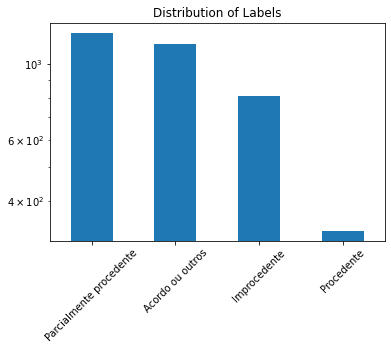

In [9]:
# 19. Criar graficos de distribuição de classes
import matplotlib.pyplot as plt
%matplotlib inline

print(df_anot['label'].value_counts())
df_anot['label'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')
plt.xticks(rotation=45)

In [18]:
df_proc = df_anot.loc[(df_anot["label"] == "Procedente")]
df_proc

text  \
4     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
13    PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
21    PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
28    23 VARA DO TRABALHO DO RIO DE JANEIRO Processo...   
36    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
...                                                 ...   
3482  PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
3489  PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
3493  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
3503  SENTENÇA PJe   RELATÓRIO     Tratase de Ação C...   
3506  PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   

                                                   disp       label  
4     go de chefe do Poder Executivo estadual assegu...  Procedente  
13    ão para rediscussão dos cálculos uma vez que o...  Procedente  
21    cárias corrente e poupança vinculadas ao Contr...  Procedente  
28     a Sumula n 381 do C TST Em relação aos danos ...  Procedente  
36    tes do cargo de chefe do Poder Executivo estad...  Procedente  
...                                                 ...         ...  
3482  ência  de  juros  da  poupança  na  fase  prép...  Procedente  
3489  rcelamento pela ré com a Caixa Econômica Feder...  Procedente  
3493  rgo de chefe do Poder Executivo estadual  asse...  Procedente  
3503  tes do cargo de chefe do Poder Executivo estad...  Procedente  
3506  cia reciproca ainda seguindo os nortes  da  me...  Procedente  

[327 rows x 3 columns]

In [23]:
df_improc = df_anot.loc[(df_anot["label"] == "Improcedente")]
tam = len(df_proc)
df_improc = df_improc[0:tam]
df_improc

text  \
0     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
9     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
10    Relatório  Vistos SINDICATO  DOS  EMPREGADOS  ...   
14    Relatório     DECISÃO DE EMBARGOS  EXECUÇÃO   ...   
17    Relatório  Fundamentação  PODER JUDICIÁRIO FED...   
...                                                 ...   
1431     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABAL...   
1433            Tratase de Ação Civil Pública na qua...   
1441  PODER JUDICIÁRIO FEDERAL JUSTIÇA DO TRABALHO T...   
1447         PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TR...   
1448  JUSTIÇA DO TRABALHO TRIBUNAL REGIONAL DO TRABA...   

                                                   disp         label  
0     pitase  já  foi  amplamente  analisado  por  e...  Improcedente  
9     te reclamante eis que sua situação de hipossuf...  Improcedente  
10    edidos inexistindo causa de pedir própria rest...  Improcedente  
14    o o dia 2532015 como o marco inicial para a ap...  Improcedente  
17    S ADVOCATÍCIOS   Mesmo após a promulgação da C...  Improcedente  
...                                                 ...           ...  
1431  el a Súmula 67 deste E TRT   Flagrante pois a ...  Improcedente  
1433  ratase de Ação Civil Pública na qual o SIND DO...  Improcedente  
1441  gentes de segurança admitidos pela CBTU median...  Improcedente  
1447  : ser a parte reclamante beneficiária da gratu...  Improcedente  
1448  aplicabilidade  A  Fazenda  Pública  quando co...  Improcedente  

[327 rows x 3 columns]

In [24]:
df_parcproc = df_anot.loc[(df_anot["label"] == "Parcialmente procedente")]
tam = len(df_proc)
df_parcproc = df_parcproc[0:tam]
df_parcproc

text  \
1    Relatório  ADILEX DIAS DE MATOS ajuizou a pres...   
2    Relatório    1 Vara do Trabalho de Barra Mansa...   
3       PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABAL...   
6    Relatório  Fundamentação     Dispositivo  5 Va...   
7    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
..                                                 ...   
896  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
900  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
902  Relatório  Fundamentação  PODER JUDICIÁRIO FED...   
903  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
906  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   

                                                  disp  \
1    dos  Previdência Social incluídos a atualizaçã...   
2    459 conforme fartamente já decidiram nossos Tr...   
3    eficiária da gratuidade da Justiça e estar ass...   
6    r a aplicação subsidiária do Art85 do CPC Art7...   
7     Pública direta e indireta respondem subsidiar...   
..                                                 ...   
896  ada não decorre pura e simplesmente da sucumbê...   
900  trabalho sendo certo que a sumula 331 não auto...   
902   de renda retido na fonte será efetuado até o ...   
903  ibilidade durante 5 cinco anos CPC art 98 3 No...   
906  ndentes a 1 ao mês a  partir do ajuizamento da...   

                       label  
1    Parcialmente procedente  
2    Parcialmente procedente  
3    Parcialmente procedente  
6    Parcialmente procedente  
7    Parcialmente procedente  
..                       ...  
896  Parcialmente procedente  
900  Parcialmente procedente  
902  Parcialmente procedente  
903  Parcialmente procedente  
906  Parcialmente procedente  

[327 rows x 3 columns]

In [25]:
df_outros = df_anot.loc[(df_anot["label"] == "Acordo ou outros")]
tam = len(df_proc)
df_outros = df_outros[0:tam]
df_outros

text  \
5     Tratase  de  Ação  Civil  Pública  ajuizada  p...   
12    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
16    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
20    PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
22    Relatório  Fundamentação  Dispositivo  PODER J...   
...                                                 ...   
1014  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1016  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1019  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1031  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1032  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   

                                                   disp             label  
5     ertinência temática entre os fins sociais da e...  Acordo ou outros  
12    no evidenciado transmudando a natureza e o des...  Acordo ou outros  
16     a petição inicial protocolada pelo Ministério...  Acordo ou outros  
20     Trabalhista a função  administrativa de homol...  Acordo ou outros  
22    x positis EXTINGUO SEM RESOLUÇÃO DO MÉRITO a p...  Acordo ou outros  
...                                                 ...               ...  
1014                                    balho Titular    Acordo ou outros  
1016                                                 na  Acordo ou outros  
1019                                                 na  Acordo ou outros  
1031  iados nem entre estes e os tomadores de serviç...  Acordo ou outros  
1032   pelo autor que fica dispensado do recolhiment...  Acordo ou outros  

[327 rows x 3 columns]

In [26]:
df_anot_balanc = pd.concat([df_proc,df_improc, df_parcproc,df_outros])
#pd.bindrows()

In [27]:
df_anot_balanc

text  \
4     PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
13    PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
21    PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
28    23 VARA DO TRABALHO DO RIO DE JANEIRO Processo...   
36    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
...                                                 ...   
1014  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1016  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1019  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1031  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1032  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   

                                                   disp             label  
4     go de chefe do Poder Executivo estadual assegu...        Procedente  
13    ão para rediscussão dos cálculos uma vez que o...        Procedente  
21    cárias corrente e poupança vinculadas ao Contr...        Procedente  
28     a Sumula n 381 do C TST Em relação aos danos ...        Procedente  
36    tes do cargo de chefe do Poder Executivo estad...        Procedente  
...                                                 ...               ...  
1014                                    balho Titular    Acordo ou outros  
1016                                                 na  Acordo ou outros  
1019                                                 na  Acordo ou outros  
1031  iados nem entre estes e os tomadores de serviç...  Acordo ou outros  
1032   pelo autor que fica dispensado do recolhiment...  Acordo ou outros  

[1308 rows x 3 columns]

In [29]:
df_anot_balanc = df_anot_balanc.sample(frac=1).reset_index(drop=True)
df_anot_balanc

text  \
0     PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
1     PODER JUDICIÁRIO JUSTIÇA DO TRABALHO TRIBUNAL ...   
2     Aos 29 dias do mês de fevereiro do ano de 2016...   
3     Relatório  Fundamentação  PODER JUDICIÁRIO FED...   
4        TERMO DA SENTENÇA   Processo: 0010948982015...   
...                                                 ...   
1303  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1304  Relatório  Vistos etc  Tratase  de  Embargos  ...   
1305  Relatório  A parte Autora ajuizou execução de ...   
1306  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
1307  Relatório  2 VARA DO TRABALHO DE VOLTA REDONDA...   

                                                   disp  \
0     r cento ao mês de setembro de 2001a junho de  ...   
1     ados  em  grupo  de  risco  ou  de  redução  d...   
2     9 é cristalina O obreiro deve preencher dois r...   
3     ue o 1 réu foi o sucumbente no objeto da períc...   
4     sindicato de classe   Conforme se infere a par...   
...                                                 ...   
1303  tram que não houve redução do valor do salário...   
1304  HOS empresa do poder público atua na atividade...   
1305  es mas limitados aos policiais federais agente...   
1306  s de advogado Os honorários advocatícios nas l...   
1307   uma pessoa física tal possibilidade somente s...   

                        label  
0                  Procedente  
1                Improcedente  
2                Improcedente  
3     Parcialmente procedente  
4                Improcedente  
...                       ...  
1303             Improcedente  
1304         Acordo ou outros  
1305         Acordo ou outros  
1306  Parcialmente procedente  
1307         Acordo ou outros  

[1308 rows x 3 columns]

Improcedente               327
Acordo ou outros           327
Procedente                 327
Parcialmente procedente    327
Name: label, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Improcedente'),
  Text(1, 0, 'Acordo ou outros'),
  Text(2, 0, 'Procedente'),
  Text(3, 0, 'Parcialmente procedente')])

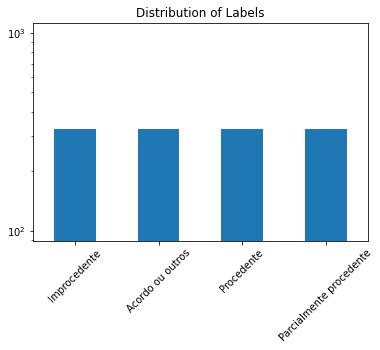

In [31]:
# 19. Criar graficos de distribuição de classes
import matplotlib.pyplot as plt
%matplotlib inline

print(df_anot_balanc['label'].value_counts())
df_anot_balanc['label'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')
plt.xticks(rotation=45)

In [32]:
DsClassAnot = Dataset.from_pandas(df_anot_balanc)
DsClassAnot.save_to_disk(DS_FOLDER+"DsClassAnot/")

Text(0.5, 1.0, 'Distribution of text length in words')

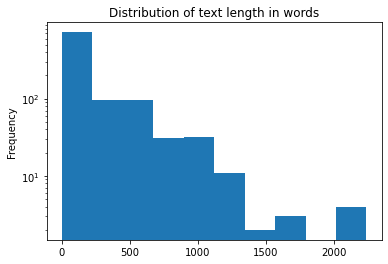

In [147]:
%matplotlib inline

# 20.

import matplotlib.pyplot as plt


df_anot['disp'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of text length in words')

In [41]:
# 21.
# Split in Train, Validation and Test sets
# https://datascience.stackexchange.com/questions/103249/how-to-use-train-test-split-with-existing-dataset
# https://discuss.huggingface.co/t/split-dataframe-into-validation-and-train-split/16678

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_anot, test_size = 0.3)
#df_validation, df_test  = train_test_split(temp, test_size = 0.5)

#df_test, df_temp     = train_test_split(test, test_size = 0.9965)

df_train.reset_index(inplace=True)
#df_validation.reset_index(inplace=True)
df_test.reset_index(inplace=True)

print(len(df_train),len(df_test))

915 393


In [42]:
# 22. Remove 'index', 'text', 'classif' column and create a features dataframe/datset
df_train.drop('index', inplace=True, axis=1)
df_test.drop('index', inplace=True, axis=1)

/home/info/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [43]:
df_train

text  \
0    Relatório  Vistos etc  BÁBARA PAIXÃO DE ABREU ...   
1    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
2    Relatório  1 V A R A D O T R A B A L H O D A C...   
3    PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
4     35 VARA DO TRABALHO DO RIO DE JANEIRO  PROCES...   
..                                                 ...   
910  PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRABALHO ...   
911        PODER JUDICIÁRIO FEDERAL  JUSTIÇA DO TRA...   
912  Relatório  PODER JUDICIÁRIO FEDERAL JUSTIÇA DO...   
913  Relatório  PODER JUDICIÁRIO FEDERAL JUSTIÇA DO...   
914  Relatório  Fundamentação  PODER JUDICIÁRIO FED...   

                                                  disp  \
0    ao da competência alínea b do inciso I do arti...   
1    o do imposto de renda independentemente da nat...   
2    m editada Súmula 463 do TST   6 Dos honorários...   
3                                                   na   
4    to sobre o valor da condenação do proveito eco...   
..                                                 ...   
910  apreciadas por este juízo na decisão de Id 51a...   
911  DORES DE SERVIÇOS EM FURNAS CENTRAIS ELÉTRICAS...   
912  ípio de propriedade do executado a teor do ref...   
913  ência da ação     É o relatório  Fundamentação...   
914  gação sendo certo que em sede trabalhista tal ...   

                       label  
0    Parcialmente procedente  
1    Parcialmente procedente  
2                 Procedente  
3           Acordo ou outros  
4                 Procedente  
..                       ...  
910               Procedente  
911               Procedente  
912               Procedente  
913         Acordo ou outros  
914  Parcialmente procedente  

[915 rows x 3 columns]

In [44]:
# 23. Cria os Dataset e o DatasetDict e salva em disco (actually MyGoogleDrive)
from datasets import Dataset, DatasetDict

dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

dataset_target = DatasetDict()
dataset_target['train'] = dataset_train
dataset_target['test'] = dataset_test

#dataset_target.save_to_disk("/content/drive/MyDrive/DenunBertV2")
#DsClassAnot = Dataset.from_pandas(df)
dataset_target.save_to_disk(DS_FOLDER+"DsClassAnot/Train_Test")  # Especificar a pasta DsClassAnot?


In [52]:
Lista_Labels = list()
Lista_Labels = dataset_train['label']
Lista_Labels

['Parcialmente procedente',
 'Parcialmente procedente',
 'Procedente',
 'Acordo ou outros',
 'Procedente',
 'Improcedente',
 'Procedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Improcedente',
 'Parcialmente procedente',
 'Acordo ou outros',
 'Improcedente',
 'Improcedente',
 'Procedente',
 'Parcialmente procedente',
 'Parcialmente procedente',
 'Procedente',
 'Parcialmente procedente',
 'Procedente',
 'Improcedente',
 'Procedente',
 'Parcialmente procedente',
 'Parcialmente procedente',
 'Parcialmente procedente',
 'Parcialmente procedente',
 'Acordo ou outros',
 'Procedente',
 'Procedente',
 'Improcedente',
 'Acordo ou outros',
 'Parcialmente procedente',
 'Improcedente',
 'Acordo ou outros',
 'Parcialmente procedente',
 'Improcedente',
 'Acordo ou outros',
 'Parcialmente procedente',
 'Acordo ou outros',
 'Procedente',
 'Procedente',
 'Improcedente',
 'Procedente',
 'A

In [158]:
 ### APLICANDO O MODELO DE PeR (Ou Q&A)NO DATASET PARA EXTRAIR A CLASSIFICAÇÃO DA SENTENÇA. ###

In [46]:
import datasets

FOLDER_BASE = "/home/info/MyNotebooks/Datasets/SentencasTRT1/"
DS_FOLDER   = FOLDER_BASE + "DS/"

DsClassAnot = datasets.load_from_disk(DS_FOLDER+"DsClassAnot/Train_Test")
DsClassAnot

DatasetDict({
    train: Dataset({
        features: ['text', 'disp', 'label'],
        num_rows: 915
    })
    test: Dataset({
        features: ['text', 'disp', 'label'],
        num_rows: 393
    })
})

In [47]:
import transformers
from transformers import AutoModelForTokenClassification, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import pipeline

model_name_qa  = "pierreguillou/bert-large-cased-squad-v1.1-portuguese"

In [48]:
model_qa   = AutoModelForQuestionAnswering.from_pretrained(model_name_qa)
tokenz_qa  = AutoTokenizer.from_pretrained(model_name_qa)
qa  = pipeline("question-answering", model=model_qa, tokenizer=tokenz_qa)

In [49]:
# 24.
#
def apply_qa(example):
    questao = "julgo ou decido?"
    
    output = qa(question=questao, context=example['disp'])   #No disp - Dispositivo ou no text - texto completo da sentença
    
    resposta = output['answer'].lower()
    
    if (("parcialmente procedente" in resposta) or ("em parte" in resposta)):
        resposta = "Parcialmente procedente"

    elif ("improcedente" in resposta):
        resposta = "Improcedente"

    elif ("procedente" in resposta):
        resposta = "Procedente"

    else:
        resposta = "Acordo ou outros"
    
    example['predicted_labels'] = resposta
    return (example)

In [51]:
# 25.
DS = DsClassAnot['train']
DS_Applied_PeR = DS.map(apply_qa)

  0%|          | 0/915 [00:00<?, ?ex/s]

In [255]:
contexto = DsClassAnot['train']['text'][5]
contexto

'Relatório  Vistos etc   CONF NAC DOS TRAB NAS EMP DE REF COL REF CONV REST IND COZ IND E AFINS FED INTEREST TRABNAS EMPREFCOL REF CONV COZ IND E AFINS e SINDICATO DOS TRABALHADORES NAS EMPRESAS DE REFEICOES COLETIVAS REFEICOES RAPIDASFAST FOOD E AFINS DO ESTADO DO RIO DE JANEIRO  SINDIREFEICOESRJ ajuizaram ação civil pública em face de SODEXO DO BRASIL COMERCIAL SA pelos motivos expostos na peça de ingresso A Ré apresentou defesa juntada eletronicamente  Conciliação rejeitada Juntaramse documentos Sem mais provas Proposta conciliatória final rejeitada Razões finais remissivas Éo relatório     Fundamentação  Trata de ação civil pública na qual pretendem os Autores a antecipação dos efeitos da tutela visando que a parte ré emita guia e providencie o efetivo recolhimento dos percentuais legais em favor das entidades Autoras respeitado o percentual de 60 para o Sindicato 15 para a Federação e 5 para a Confederação art 589 da CLT decorrente do desconto de um dia de trabalho de todos os tra

In [273]:
contexto = DsClassAnot['train']['text'][1]
questao = "Qual é a Jurisprudência"
resp = qa(question=questao, context=contexto)['answer']
resp

'e'

In [ ]:
def apply_qa_v2(example, question, campo):
    
    output = qa(question=question, context=example['text'])   #No disp - Dispositivo ou no text - texto completo da sentença
    
    resposta = output['answer']
       
    example[campo] = resposta
    return (example)

In [ ]:
DS = DsClassAnot['test']
DS_Applied_PeR = DS.map(apply_qa("Quem é Juiz do Trabalho?", "magistrado")

In [ ]:
DS_Applied_PeR = DS.map(apply_qa("Quem é Juiz do Trabalho?", "magistrado")

In [167]:
DS_Applied_PeR['predicted_labels']

['Acordo ou outros',
 'Parcialmente procedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Procedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Improcedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Procedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Procedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Improcedente',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou outros',
 'Acordo ou

In [171]:
print("Labels:       | Predicted: \n")
for i in range(len(Lista_Labels)):
    print(Lista_Labels[i]," | ", DS_Applied_PeR['predicted_labels'][i])

Labels:       | Predicted: 

Acordo ou outros  |  Acordo ou outros
Parcialmente procedente  |  Parcialmente procedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Improcedente  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Procedente  |  Procedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Improcedente  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Improcedente  |  Improcedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Procedente  |  Acordo ou outros
Procedente  |  Procedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outro

Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Improcedente  |  Improcedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Procedente  |  Procedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Procedente  |  Procedente
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Procedente  |  Acordo ou outros
Acordo ou outros  |  Acordo ou outros
Acordo ou ou

In [53]:
from sklearn import metrics

print(metrics.classification_report(Lista_Labels, DS_Applied_PeR['predicted_labels'], labels=["Acordo ou outros", "Improcedente", "Procedente","Parcialmente procedente"]))

                         precision    recall  f1-score   support

       Acordo ou outros       0.51      0.99      0.67       230
           Improcedente       0.90      0.64      0.75       225
             Procedente       0.92      0.65      0.76       235
Parcialmente procedente       0.97      0.60      0.74       225

               accuracy                           0.72       915
              macro avg       0.82      0.72      0.73       915
           weighted avg       0.82      0.72      0.73       915



In [ ]:
'''
                         precision    recall  f1-score   support

       Acordo ou outros       0.71      1.00      0.83       479
           Improcedente       1.00      0.12      0.22       116
             Procedente       0.90      0.10      0.18        88
Parcialmente procedente       0.33      0.06      0.10        17

               accuracy                           0.72       700
              macro avg       0.74      0.32      0.33       700
           weighted avg       0.77      0.72      0.63       700
'''

In [ ]:
# Qual a fundamentação dos que foram considerados procedentes e dos que foram considerados improcedentes, para 
# cada fato?!

In [108]:
questao  = "procedencia"
contexto = DS_Applied_PeR['text'][1][-512:-1]
output   = qa(question=questao, context=contexto)
resposta = output['answer'].lower()
resposta

'julgase extinto o processo sem resolução de mérito'

In [101]:
contexto

'2 Vara do Trabalho do Rio de Janeiro   ACP 01001388720185010002   SINDICATO DOS INST E EMP EM AUTO ESC DE AP DO EST DO RJ X AUTO ESCOLA JORGE LTDA  EPP   Vistos etc   Tratase de Ação Civil Pública proposta pelo SINDICATO DOS INST E EMP EM AUTO ESC DE AP DO EST DO RJ pleiteando em síntese que seja declarada a inconstitucionalidade de forma difusa da Lei n 134672017 relativamente as alterações promovidas nos artigos 545 578 579 582 583 587 da CLT nos termos da fundamentação supra por incompatibilidade com os '

In [91]:
DS_Applied_PeR['label'][1]

'Procedente'

In [43]:
for i in range(len(DsClassAnot)):
    print(i, " - ", DsClassAnot['train']['disp'][i], "\nCONCLUSÃO: ", DsClassAnot['train']['label'][i], "\n\n")

0  -  da ao pagamentocomprovação das contribuições previdenciárias supostamente devidas no decorrer da relação havida com a parte reclamante  De acordo com o artigo 114 inciso VIII da Constituição da República a Justiça  do Trabalho é competente para executar as contribuições previdenciárias decorrentes das sentenças que proferir  A partir da interpretação do referido dispositivo chegouse  conclusão hoje majoritária de que tal competência apenas abrange as contribuições diretamente incidentes sobre o montante objeto de acordo ou condenação Não engloba pois eventuais contribuições calculadas sobre parcelas pagas durante o contrato de emprego  até porque se foram pagas não são decorrentes da condenação trabalhista  O Tribunal Superior do Trabalho com efeito tem entendimento consolidado nesse sentido cristalizado na Súmula 368 item I cujo teor é o seguinte: a competência da Justiça do Trabalho quanto  execução das contribuições previdenciárias limitase s sentenças condenatórias em pecúnia

In [ ]:
### Trabalhando com as entidades nomeadas de cada dispositivo ou para os 512 primeiros tokens do texto da sentença.

In [44]:
list_disp = DsClassAnot['train']['disp']

In [46]:
#print(list_disp[0])

In [47]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint =  "pierreguillou/ner-bert-base-cased-pt-lenerbr"

tokenizer_ner = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, aggregation_strategy='simple')

model_ner = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

loading file https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr/resolve/main/vocab.txt from cache at /home/info/.cache/huggingface/transformers/ee3bd05f7058512befa37171e0603ef7cbd95bb2eaa031f38dd85e775288d884.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr/resolve/main/tokenizer.json from cache at /home/info/.cache/huggingface/transformers/6b5be61b8d9f1b731cae79364fc7a2aa504191387eee9f7a46fa2b5582db531f.91dcee4cd95491b853dd6840c5b649662400e640055fc8420941b94230b798fe
loading file https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr/resolve/main/special_tokens_map.json from cache at /home/info/.cache/huggingface/transformers/3117576761f9b0c64221a5fd0c35c39b358a083040a295145a12c3cbd9e09d4c.dd8bd9bfd3664b530ea4e645105f557769387b3da9

In [48]:
# Aplica ao primeiro item da lista, que representa a coluna disp do dataset
input_text = list_disp[0]
input_text

'da ao pagamentocomprovação das contribuições previdenciárias supostamente devidas no decorrer da relação havida com a parte reclamante  De acordo com o artigo 114 inciso VIII da Constituição da República a Justiça  do Trabalho é competente para executar as contribuições previdenciárias decorrentes das sentenças que proferir  A partir da interpretação do referido dispositivo chegouse  conclusão hoje majoritária de que tal competência apenas abrange as contribuições diretamente incidentes sobre o montante objeto de acordo ou condenação Não engloba pois eventuais contribuições calculadas sobre parcelas pagas durante o contrato de emprego  até porque se foram pagas não são decorrentes da condenação trabalhista  O Tribunal Superior do Trabalho com efeito tem entendimento consolidado nesse sentido cristalizado na Súmula 368 item I cujo teor é o seguinte: a competência da Justiça do Trabalho quanto  execução das contribuições previdenciárias limitase s sentenças condenatórias em pecúnia que 

In [52]:

from transformers import pipeline

ner = pipeline(task="ner", model=model_ner, tokenizer=tokenizer_ner, aggregation_strategy='max')



def extrai_ner(example):
    input_text = example['disp'] # DS_PADDED[17004]['texto_padded']
    print("Input Text: ", input_text)
    ner_list = list()
    
    res = ner(input_text)

    pessoas = list()
    organizacoes = list()
    jurisprudencias = list()


    for i in range(len(res)):
        if res[i]['entity_group'] == 'PESSOA':
            pessoas.append(res[i]['word'])

        if res[i]['entity_group'] == 'ORGANIZACAO':
            organizacoes.append(res[i]['word'])

        if res[i]['entity_group'] == 'JURISPRUDENCIA':
            jurisprudencias.append(res[i]['word'])
            
        # Acrescentar mais classes NER!

    pessoas = set(pessoas)    
    organizacoes = set(organizacoes)
    jurisprudencias = set(jurisprudencias)
    print(pessoas)
    #ner_list.append(list(zip(pessoas, organizacoes, jurisprudencias)))
    ner_list.append({'pessoas': pessoas, 'organizacoes': organizacoes, 'jurisprudencias': jurisprudencias})
    return(ner_list)


In [55]:
#extrai_ner(str(input_text))

In [54]:
#DS_NER =  DsClassAnot['train'].map(extrai_ner)

In [274]:
DsClassAnot

DatasetDict({
    train: Dataset({
        features: ['text', 'disp', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['text', 'disp', 'label'],
        num_rows: 300
    })
})

In [ ]:
print(len(DsClassAnot))

In [ ]:
# Criar dataframe a partir do dataset e retirar valores "na".
# Analisar distribuição das classes 

In [6]:
# https://discuss.huggingface.co/t/dataset-to-pandas-dataframe-and-back-to-dataset/14801
import pandas as pd

df_anot = pd.DataFrame(DsClassAnot)
df_anot

ValueError: arrays must all be same length

In [ ]:
#### Cria os id para a classificação. ####
df_anot['label'] = ""

for i in range(len(df_anot)):
    if df_anot['classif'][i] == "Parcialmente procedente":
        df_anot['label'][i] = 1
    else:
        if df_anot['classif'][i] == "Improcedente":
            df_anot['label'][i] = 2
        else:
            if df_anot['classif'][i] == "Procedente":
                df_anot['label'][i] = 3
            else:
                df_anot['label'][i] = 4
    

In [ ]:
df_anot['disp'][3]

In [ ]:
new_df = df_anot.dropna(inplace = True)

In [ ]:
new_df['disp'][3]

In [ ]:
#df_anot.dropna(subset=['disp'], inplace=True)

In [ ]:
print(len(new_df))

In [ ]:
for i in range(100):
    if df_anot['classif'][i] == "Acordo ou outros":
        print(df_anot['disp'][i]," - " , df_anot['classif'][i])

In [ ]:
df_train

In [ ]:
DsClassAnot

In [ ]:
# Split in Train, Validation and Test sets
# https://datascience.stackexchange.com/questions/103249/how-to-use-train-test-split-with-existing-dataset
# https://discuss.huggingface.co/t/split-dataframe-into-validation-and-train-split/16678

from sklearn.model_selection import train_test_split

df_train, temp          = train_test_split(df_anot, test_size = 0.4)
df_validation, df_test  = train_test_split(temp, test_size = 0.5)

#df_test, df_temp     = train_test_split(test, test_size = 0.9965)

df_train.reset_index(inplace=True)
df_validation.reset_index(inplace=True)
df_test.reset_index(inplace=True)

print(len(df_train),len(df_validation),len(df_test))

In [ ]:
# Remove 'index', 'text', 'classif' column and create a features dataframe/datset
df_train.drop('index', inplace=True, axis=1)
df_train.drop('text', inplace=True, axis=1)
df_train.drop('classif', inplace=True, axis=1)

df_validation.drop('index', inplace=True, axis=1)
df_validation.drop('text', inplace=True, axis=1)
df_validation.drop('classif', inplace=True, axis=1)

df_test.drop('index', inplace=True, axis=1)
df_test.drop('text', inplace=True, axis=1)
df_test.drop('classif', inplace=True, axis=1)

In [ ]:
df_train

In [ ]:
# Cria os Dataset e o DatasetDict e salva em disco (actually MyGoogleDrive)
from datasets import Dataset, DatasetDict

dataset_train = Dataset.from_pandas(df_train)
dataset_validation = Dataset.from_pandas(df_validation)
dataset_test = Dataset.from_pandas(df_test)

dataset_target = DatasetDict()
dataset_target['train'] = dataset_train
dataset_target['validation'] = dataset_validation
dataset_target['test'] = dataset_test

#dataset_target.save_to_disk("/content/drive/MyDrive/DenunBertV2")
#DsClassAnot = Dataset.from_pandas(df)
dataset_target.save_to_disk(DS_FOLDER+"DsClassAnot/")  # Especificar a pasta DsClassAnot?


In [ ]:
dataset_target

In [ ]:
#DS = datasets.load_from_disk(DS_FOLDER+"DsClassAnot/")
#DS

In [ ]:
print(len(dataset_target['train']),len(dataset_target['validation']),len(dataset_target['test']))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print(df_train['label'].value_counts())
df_train['label'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')

In [ ]:
# TRAIN SET 
import matplotlib.pyplot as plt
%matplotlib inline

df_train['disp'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of text length in words')

In [ ]:
# TRAIN SET
df_train['disp'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of text length in characters')

In [ ]:
# Mais graficos EDA:
# https://www.kaggle.com/code/somesh88/chapter-2-nlp-with-transformers/notebook


In [ ]:
import numpy as np

print('Average word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.mean(df_train['disp'].apply(lambda x: len(x.split())))))
print('Max word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.max(df_train['disp'].apply(lambda x: len(x.split())))))
print('Min word length of texts \'disp\' in dataset is {0:.0f}.'.format(np.min(df_train['disp'].apply(lambda x: len(x.split())))))
print('Average character length of texts \'disp\' in dataset is {0:.0f}.'.format(np.mean(df_train['disp'].apply(lambda x: len(x)))))

In [ ]:
#df_train_nona = df_train.dropna()
#print('Min word length of texts in dataset is {0:.0f}.'.format(np.min(df_train_nona['text'].apply(lambda x: len(x.split())))))

In [ ]:
# Reunir todos os pdf de seNteneças numa pasta unica antes de gerar os txt e dataset - OK
# Analisar dataset criado: Retirar os registros com classificacao null - OK
# Fazer analise de classes (para classificacoes) - OK
# Dividir o dataset em train/validation/test - OK
# Ler artigo: como avaliar um modelo de NLP. Link na lista Pessoal do WhatsApp e:
# https://blog.roboflow.com/train-test-split/
# https://python.plainenglish.io/train-test-split-explained-in-5-minutes-2e4c86a9f27a

In [ ]:
# PROXIMOS PASSOS:

In [ ]:
# Fine tuning no nosso dataset (ou parte dele) de Sentenças usando o modelo neuralmind/bert-base (ou large) na 
# tarefa de CLASSIFICACAO DE SENTENÇAS.
#
# Usar BertForSentenceClassification em Portugues: Neuralmind? Pierre Guillou? Bertimbau?
# O modelo treinado na classificacao tem que ser melhor que o regex classificou.
#
# BERTimbau - Portuguese BERT.  pre-trained BERT models trained on the Portuguese language
# Trained on the BrWaC (Brazilian Web as Corpus), a large Portuguese corpus, for 1,000,000 steps, using whole-word mask. 
# Model artifacts for TensorFlow and PyTorch can be found on: https://github.com/neuralmind-ai/portuguese-bert
#
# Tenho modelo base (Bertimbau) + Dataset_Dominio => Ajuste Fino em Text Classification
# Aplicar modelo ajustado e analisar os resultados.
#
# Notebooks para Fine tuning Text (ou Sentence) Classification:
# 

In [7]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer 

# Define the model repo
checkpoint = "neuralmind/bert-base-portuguese-cased"

In [8]:
# Download pytorch model
model_base = AutoModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Transform input tokens 
inputs = tokenizer("Hello world!", return_tensors="pt")

In [ ]:
# Model apply
outputs = model_base(**inputs)
outputs

In [ ]:
# Treinar o Classificador

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
model = BertForSequenceClassification.from_pretrained(model_checkpoint, problem_type="multi_label_classification")


NameError: name 'model_checkpoint' is not defined

In [ ]:
inputs = tokenizer("Nego provimento ao recurso", return_tensors="pt")
labels = torch.tensor([[1, 1]], dtype=torch.float) # need dtype=float for BCEWithLogitsLoss
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [ ]:
torch.nn.functional.softmax(logits, dim=-1)

In [ ]:
tokenizer.decode(logits.tolist)

In [ ]:
tokenizer.convert_ids_to_tokens(logits.tolist)

In [ ]:
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=kL8SK9LIiTda
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/training.ipynb#scrollTo=POEy0IzZhzhO
# https://github.com/huggingface/transformers/tree/main/notebooks 
# you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths.

In [12]:
model_checkpoint = "neuralmind/bert-base-portuguese-cased"

Preprocessing the data

In [17]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, truncation=True, padding=True, max_length=512, return_tensors="pt")

In [ ]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

In [ ]:
tokenizer("Hello, this one sentence!")

In [21]:
def preprocess_function(examples):
    return tokenizer(examples['disp'])

In [22]:
# preprocess_function(DS['train'][:1])

In [23]:
encoded_DS_features = DsClassAnot.map(preprocess_function, batched=True)
# , truncation=True, padding=True, max_length=512, return_tensors="pt"

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [24]:
encoded_DS_features

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'disp', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 21492
    })
    validation: Dataset({
        features: ['attention_mask', 'disp', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 7164
    })
    test: Dataset({
        features: ['attention_mask', 'disp', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 7164
    })
})

In [ ]:

#encoded_DS_final = DS_final.map(preprocess_function, batched=True)
#DS_label = DS.map(convert_label_to_id, batched=True)

In [ ]:
encoded_feature_DS['train'][0]

Fine-tuning the model

In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 4

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [26]:
from datasets import load_dataset, load_metric

metric_name = "accuracy" # "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]
task = "classification"
batch_size = 16

# metric = load_metric('glue', task)

In [ ]:
model_name, metric_name

In [ ]:
labels = DS['train']['classif'] # ou DS['classif']

In [ ]:
labels = ""
labels

In [27]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)
# push_to_hub=True,

In [28]:
# You can call its compute method with your predictions and labels directly and it will return a dictionary with the metric(s) value:
# metric.compute(predictions=fake_preds, references=fake_labels) 
# The metric is an instance of datasets.Metric.
# Args:
#    predictions: list of predictions to score.
#        Each translation should be tokenized into a list of tokens.
#    references: list of lists of references for each translation.
#        Each reference should be tokenized into a list of tokens.
#
# Returns: depending on the GLUE subset, one or several of:
#    "accuracy": Accuracy
#    "f1": F1 score
#    "pearson": Pearson Correlation
#    "spearmanr": Spearman Correlation
#    "matthews_correlation": Matthew Correlation
#

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    #if task != "stsb":
    #    predictions = np.argmax(predictions, axis=1)
    #else:
    #    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Import and evaluate each test batch using Matthew's correlation coefficient
#from sklearn.metrics import matthews_corrcoef
#matthews_set = []
#
#for i in range(len(true_labels)):
#  matthews = matthews_corrcoef(true_labels[i],
#                 np.argmax(predictions[i], axis=1).flatten())
#  matthews_set.append(matthews)
# Fonte: https://colab.research.google.com/github/rbkhb/NLP_IMC/blob/master/BERT_Fine_Tuning_Sentence_Classification.ipynb#scrollTo=cRaZQ4XC7kLs

In [30]:
from transformers import default_data_collator
data_collator = default_data_collator

In [31]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    data_collator=data_collator,
    train_dataset=encoded_DS_features["train"],
    eval_dataset=encoded_DS_features["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# flat_accuracy
#data_collator=data_collator,

In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: disp. If disp are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/info/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 21492
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6720


ValueError: expected sequence of length 535 at dim 1 (got 501)

In [ ]:
trainer.evaluate()

In [ ]:
# Fine tuning no nosso dataset (ou parte dele) de Denuncias usando o modelo neuralmind/LeNER (ou large) na tarefa
# de RECONHECIMENTO DE ENTIDADES
#
# Script: %%writefile HelperFunctions/createDsNERAnotated.py
#
# Usando as entetidade, criar outro datset com as Features jurimetricas estruturadas:
# Autor, Reu, Assunto/Fato, Fundamentacao Juridica, Procedencia da ACP, Vara do Trabalho, Oficio Procurador

In [ ]:
# Se para responder a questoes anteriores na criação do novo dataset for preciso:
# Usar o reconhecimento de entidades em cima do nosso datset para criar dataset de treinamento de Q&A
# Fazer ajuste (fine tuning) de um modelo Q&A_SQuAD-1.1-pt no nosso dataset de dominio criado por ultimo (acima)
# Dado o texto de uma sentença o modelo Q&A treinado por ultimo consegue responder as questoes jurimetricas/estruturantes?


In [ ]:
# Fazer reconhecimento de Entidades (modelo e tokenizador LeNER) no Corpus de Sentenças do TRT1.
# Armazenar os dados extraidos em dataset estruturado, contendo as entidades nomeadas de interesse juridico extraídas.
# Podemos usar Q&A pra extrair mais relações/entidades do Corpus, utilizando também funções Helper?
# Podemos responder perguntas mais gerais com o modelo Q&A no Corpus?
#
# Estabelecer correlações Jurimetricas entre a caracterização/classificação de fatos jurídicos (usar ds de denuncias para treinar este classificador?)
# a fundamentação legal proposta e o resultado da sentença (classificação: procedente, motivo de improcedencia, etc.).
#
Usar regex no trecho da Decisao para selecionar somente esta parte (pode vir com varios nomes). Talvez nao precisa selecionar o trecho mas procurar no documento todo
Buscar pela padrao regex, na sequencia:
Primeiro 'improcedente' ou 'Improcedente' ou 'IMPROCEDENTE'
Segundo 'parcialmente procedente' ou 'Parcialmente procedente' ou 'Parcialmente Procedente' ou 'PARCIALMENTE procedente' ou 'PARCIALMENTE PROCEDENTE' ou 'parcialmente PROCEDENTE'
Segundo.2 'parcialmente improcedente' ou 'Parcialmente improcedente' ou 'Parcialmente Imrocedente' ou 'PARCIALMENTE improcedente' ou 'PARCIALMENTE IMPROCEDENTE' ou 'parcialmente IMPROCEDENTE'
Segundo.3 'procedente em parte' ou ...
Terceiro 'procedente' ou 'Procedente' ou 'PROCEDENTE'
Quarto 'acordo'? classificar como outros?

Na medida que encontrar o padrão, remover o txt para a sub-pasta correspondente, antes de aplicar os proximos filtros
Quando detectar o padrão, extrair do text um pedaço antes+string_encontrada+um pedaço apos de modo que o 
  tamanho resultante seja uma string do tamanho que o Tokenizador processa. Guardar essa string junto ao dataset
Guardar tambem no dataset, em outra coluna, a label correspondente (id2label): 0,1,2,3,4,5
